# Data analysis

In [1]:
import json
import sys
import networkx
import pandas
import numpy

import matplotlib.pyplot as plotter
from pathlib import Path

Data dir containing all files

In [2]:
!ls -la /home/ashinde/PhD/CaffineBravery/

total 44
drwxr-xr-x 17 ashinde ashinde 4096 Dec  1 07:06 .
drwxrwxr-x  6 ashinde ashinde   84 Dec  7 19:05 ..
drwxr-xr-x  7 ashinde ashinde  124 Nov 15 11:34 app
drwxr-xr-x  4 ashinde ashinde  142 Oct 15 15:33 domains
drwxr-xr-x  8 ashinde ashinde  220 Jan 18 16:05 .git
-rw-r--r--  1 ashinde ashinde  154 May 24  2022 .gitattributes
-rw-r--r--  1 ashinde ashinde  129 May 24  2022 .gitignore
drwxrwxr-x  6 ashinde ashinde   73 Jun  7  2022 .gradle
drwxr-xr-x  3 ashinde ashinde   21 May 24  2022 gradle
-rwxr-xr-x  1 ashinde ashinde 5774 May 24  2022 gradlew
-rw-r--r--  1 ashinde ashinde 2763 May 24  2022 gradlew.bat
drwxrwxr-x  2 ashinde ashinde   52 Jul 19  2022 policies
-rw-rw-r--  1 ashinde ashinde  743 Jun  7  2022 .project
drwxrwxr-x  2 ashinde ashinde   62 Nov 29 12:57 results
drwxrwxr-x  2 ashinde ashinde   62 Nov 29 14:37 results_l1_active
drwxrwxr-x  2 ashinde ashinde  100 Nov 29 21:44 results_l1_active_critical
drwxrwxr-x  2 ashinde ashinde  102 Nov 30 00:45 results_l1_honeypot
d

In [3]:
# Data files
data_dir = Path("/home/ashinde/PhD/CaffineBravery/results_l2/")
data_files = list(data_dir.iterdir())

graph_files = list(filter(lambda x: "pol_graph" in str(x), data_files))
print(f"Policy graph files: {graph_files}")

trace_file = list(filter(lambda x: "trace" in str(x), data_files))[0]
print(f"Trace file: {trace_file}")

Policy graph files: [PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2/1795225096_attl0_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2/1141113940_attl0_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2/2120063568_defl1_active_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2/1620409359_defl1_passive_pol_graph.json')]
Trace file: /home/ashinde/PhD/CaffineBravery/results_l2/trace.json


In [4]:
def load_json(fname):

    data = None

    with open(fname) as f:
        data = json.load(f)

    return data

In [5]:
# Draw policy graphs
def to_networkx_graph(json_data):

    nodes = json_data["nodes"]
    edges = json_data["edges"]

    G = networkx.MultiDiGraph()
    labels = {}
    edge_labels = {}
    edge_print = {}

    for k, v in nodes.items():
        
        if "start" in v.keys():
            labels[k] = f"start_{v['act']}"
        else:
            labels[k] = v["act"]
        G.add_node(k)
        
    for n, e in edges.items():
        for l, _n in e.items():
            G.add_edge(n, _n, label=l)
            
            e_data = G.get_edge_data(n, _n)
            label = [l["label"] for l in e_data.values()]
            # print(label)
            edge_labels[(n, _n)] = list(e_data.keys())

    # pos = networkx.shell_layout(G, scale=1)
    # networkx.draw_networkx_labels(G, pos, labels)
    
    print(G)
    pos = networkx.nx_pydot.graphviz_layout(G, prog="neato")
    networkx.draw(G, pos, labels=labels, with_labels=True, font_size=8, alpha=0.5, width=0.2)
    plotter.show()

---
## Plot policy graphs

/home/ashinde/PhD/CaffineBravery/results_l2/1795225096_attl0_pol_graph.json
MultiDiGraph with 12 nodes and 84 edges


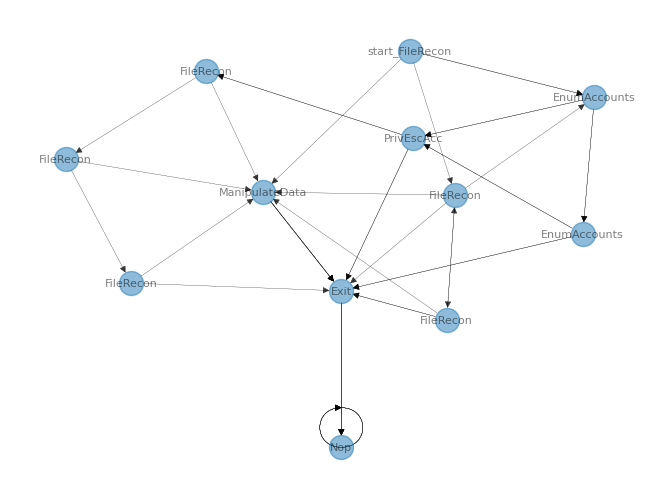

/home/ashinde/PhD/CaffineBravery/results_l2/1141113940_attl0_pol_graph.json
MultiDiGraph with 12 nodes and 84 edges


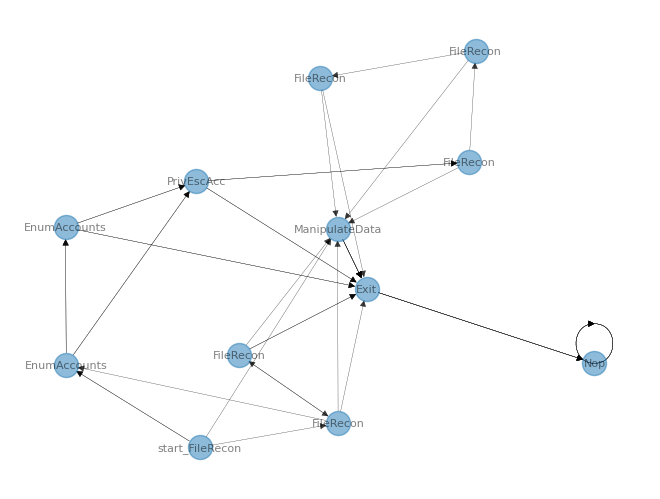

/home/ashinde/PhD/CaffineBravery/results_l2/2120063568_defl1_active_pol_graph.json
MultiDiGraph with 21 nodes and 84 edges


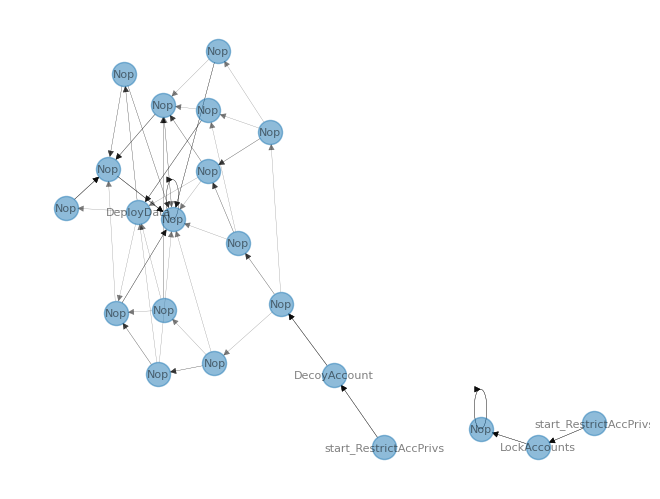

/home/ashinde/PhD/CaffineBravery/results_l2/1620409359_defl1_passive_pol_graph.json
MultiDiGraph with 14 nodes and 56 edges


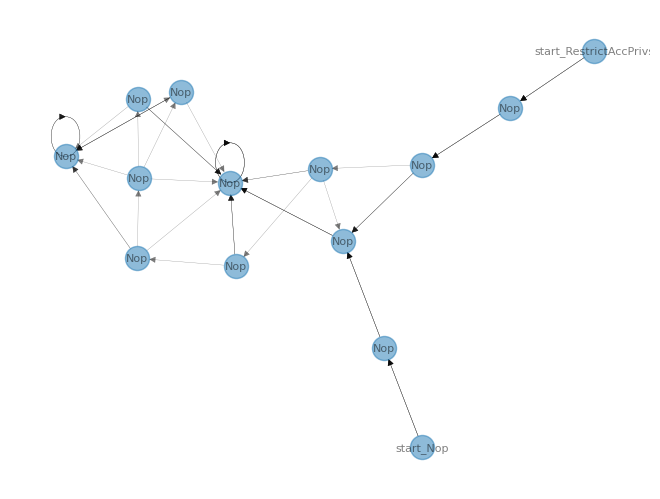

In [6]:
for g in graph_files:
    print(g)
    data = load_json(g)
    to_networkx_graph(data)

---
## Beliefs 

In [7]:
import summarize_interaction

# load json data
data = load_json(trace_file)

keys, b_traces = summarize_interaction.get_all_belief_traces(data)

print("Plotting belief divergence over")
for k in keys:
    print(k)

Plotting belief divergence over
('HostType', ['critical', 'critical_honeypot', 'honeypot'])
('HostHasData', ['no', 'yes'])
('DataPrivs', ['root', 'user'])
('EscAccounts', ['no', 'yes'])
('AccFound', ['no', 'yes'])
('DataFound', ['no', 'yes'])
('AccessLevel', ['root', 'user'])
('AttActive', ['no', 'yes'])
('DataInjected', ['no', 'yes'])


Plotting for ('HostType', ['critical', 'critical_honeypot', 'honeypot'])


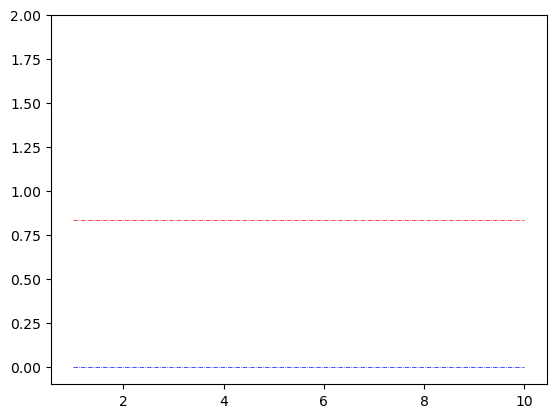

Plotting for ('HostHasData', ['no', 'yes'])


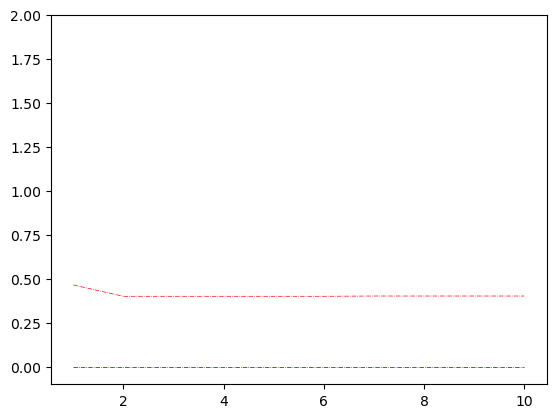

Plotting for ('DataPrivs', ['root', 'user'])


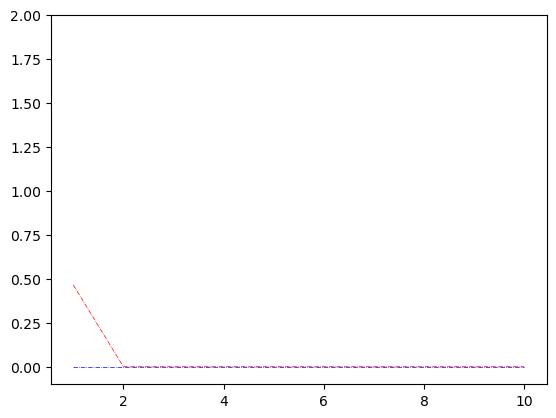

Plotting for ('EscAccounts', ['no', 'yes'])


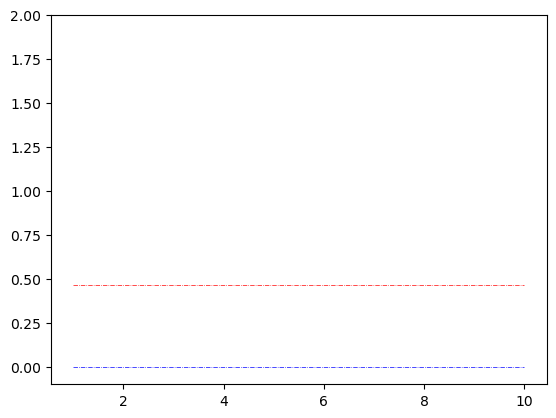

Plotting for ('AccFound', ['no', 'yes'])


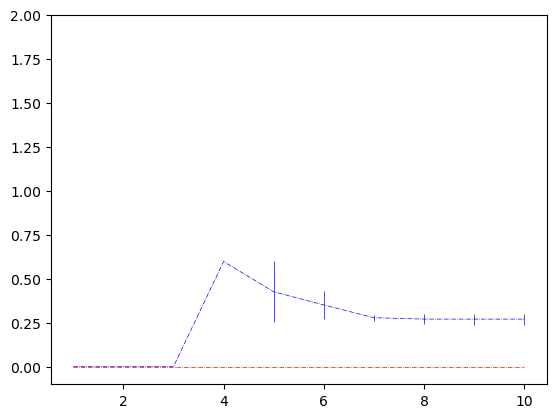

Plotting for ('DataFound', ['no', 'yes'])


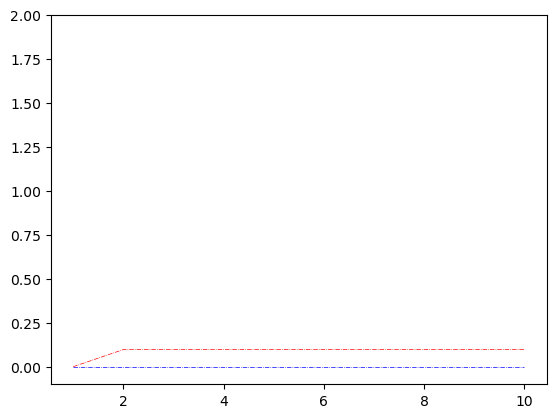

Plotting for ('AccessLevel', ['root', 'user'])


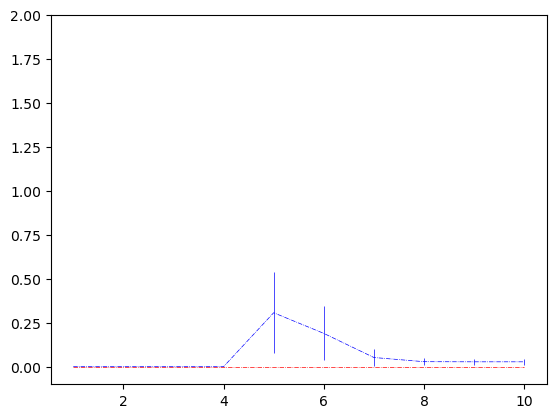

Plotting for ('AttActive', ['no', 'yes'])


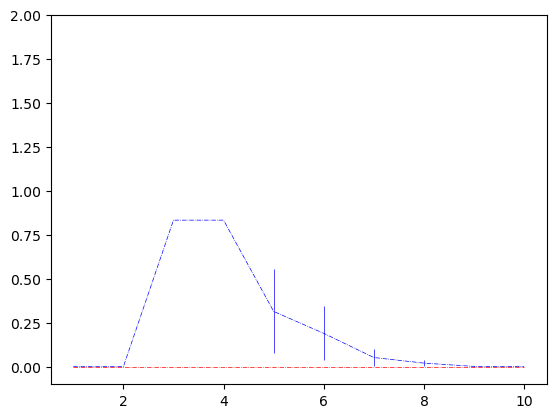

Plotting for ('DataInjected', ['no', 'yes'])


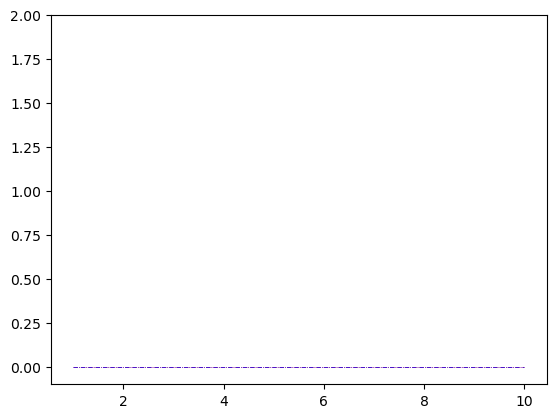

In [8]:
# Get divergence
divs = []
for b_trace in b_traces:
    divs.append(summarize_interaction.get_divergence(b_trace))
    
for i in range(len(keys)):
    print(f"Plotting for {keys[i]}")
    
    i_means = numpy.mean(divs[i][0], axis=0)
    i_dev = numpy.std(divs[i][0], axis=0)
    plotter.errorbar(numpy.linspace(1, i_means.shape[0], i_means.shape[0]), i_means, fmt='r-.', yerr=i_dev, linewidth=0.5)
    
    if len(divs[i]) > 1:
        j_means = numpy.mean(divs[i][1], axis=0)
        j_dev = numpy.std(divs[i][1], axis=0)
        plotter.errorbar(numpy.linspace(1, j_means.shape[0], j_means.shape[0]), j_means, fmt='b-.', yerr=j_dev, linewidth=0.5)
        # plotter.plot(divs[i][1].T, 'b-.', linewidth=0.5)
    
    plotter.ylim(-0.1, 2)
    plotter.show()
    

---
# Display interaction examples

,highCap,lowCap
0,0.500000,0.500000
1,0.666667,0.333333
2,0.666667,0.333333
3,0.666667,0.333333
4,0.666667,0.333333
5,0.666667,0.333333
6,0.666667,0.333333
7,0.666667,0.333333
8,0.666667,0.333333
9,0.666667,0.333333


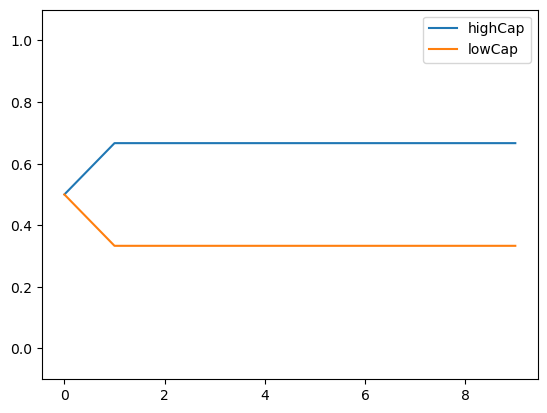

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


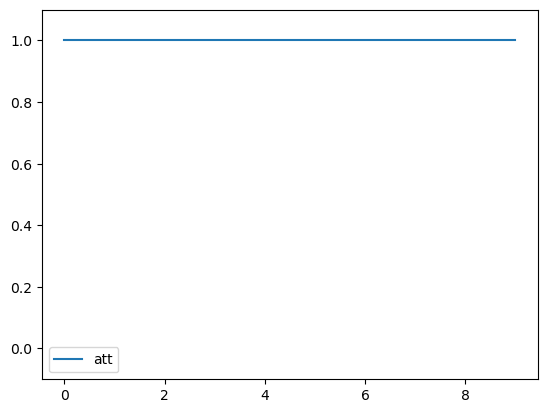

,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,FileRecon,denied|none|failure|active|perms_change,RestrictAccPrivs,file_enum
1,Exit,auth|user_files|success|terminated|none,DecoyAccount,none
2,Nop,auth|none|success|terminated|none,Nop,none
3,Nop,auth|none|success|terminated|none,Nop,login_activity
4,Nop,auth|none|success|terminated|none,Nop,none
5,Nop,denied|user_files|failure|terminated|none,Nop,none
6,Nop,denied|none|success|terminated|none,Nop,none
7,Nop,denied|user_files|failure|terminated|none,Nop,none
8,Nop,auth|none|failure|terminated|none,Nop,file_write
9,Nop,auth|none|failure|terminated|none,Nop,none


Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


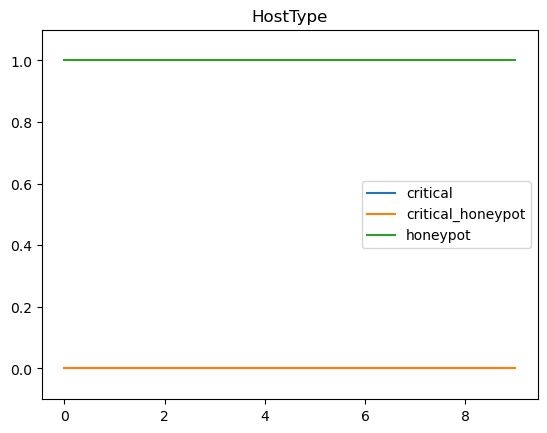

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


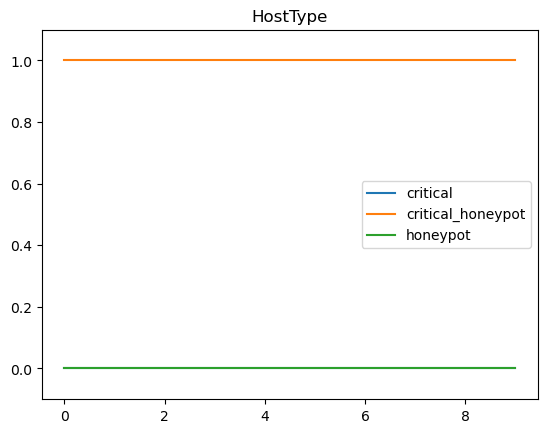

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


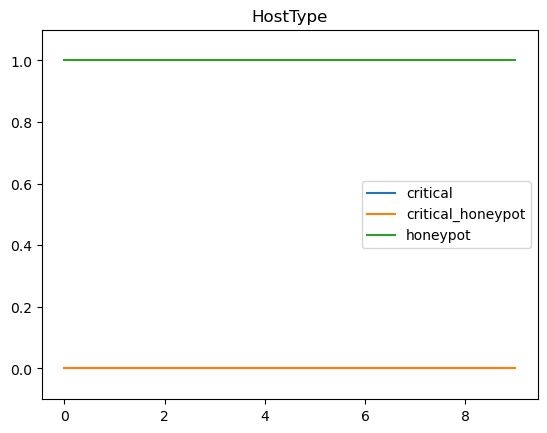

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for state:


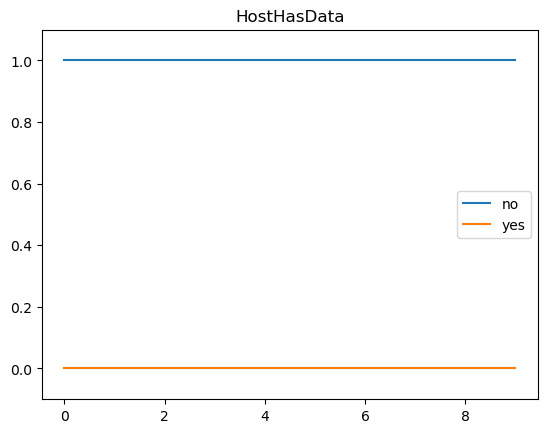

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.608108,0.391892
2,0.608108,0.391892
3,0.608108,0.391892
4,0.608108,0.391892
5,0.608108,0.391892
6,0.605625,0.394375
7,0.605625,0.394375
8,0.605625,0.394375
9,0.605625,0.394375


Plotting ('HostHasData', ['no', 'yes']) for agent_i


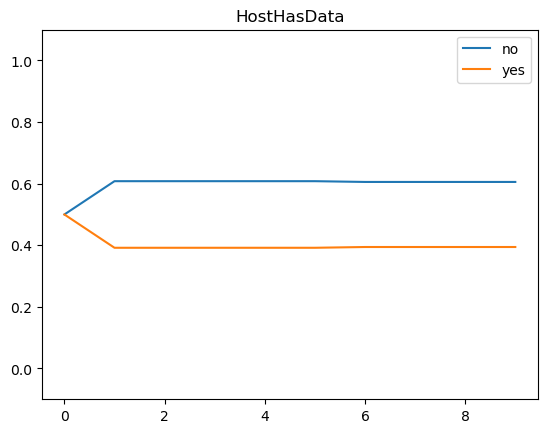

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


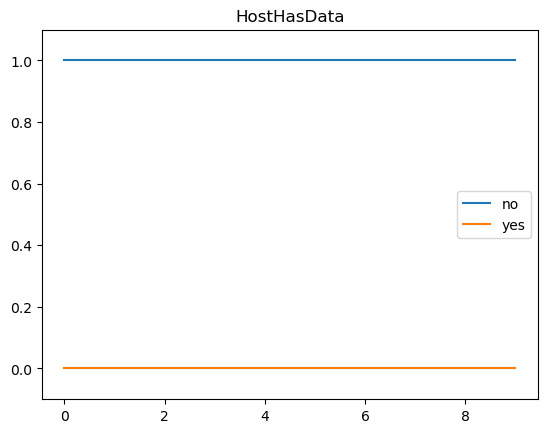

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


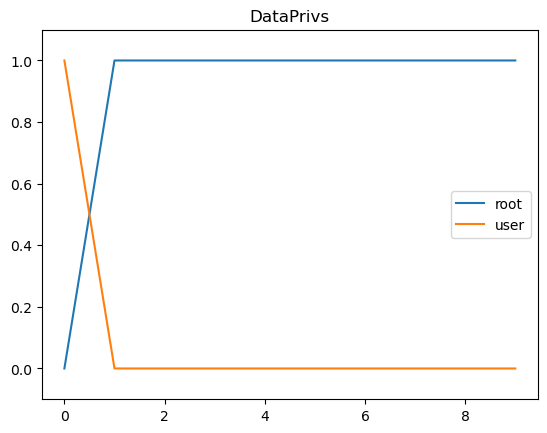

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.5,0.5
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_i


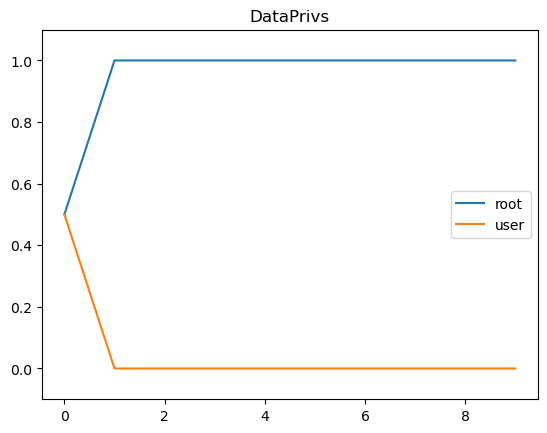

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


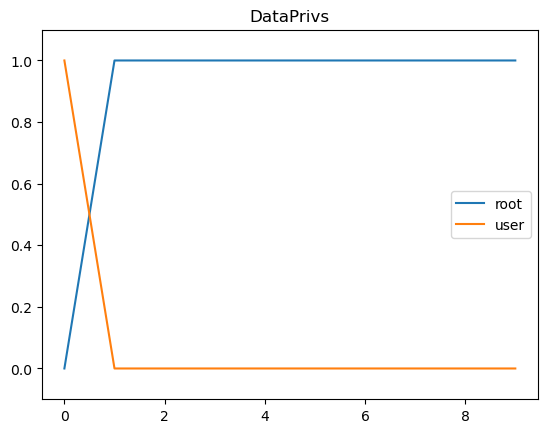

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


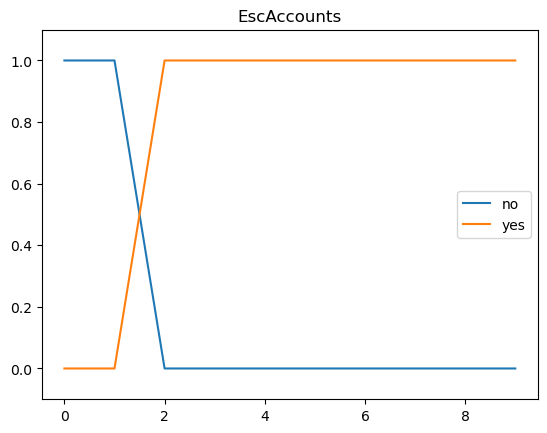

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


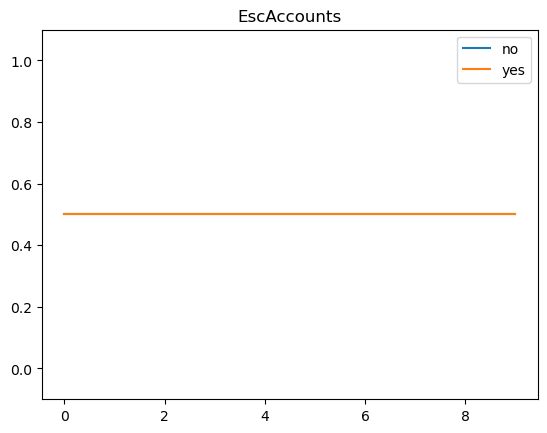

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


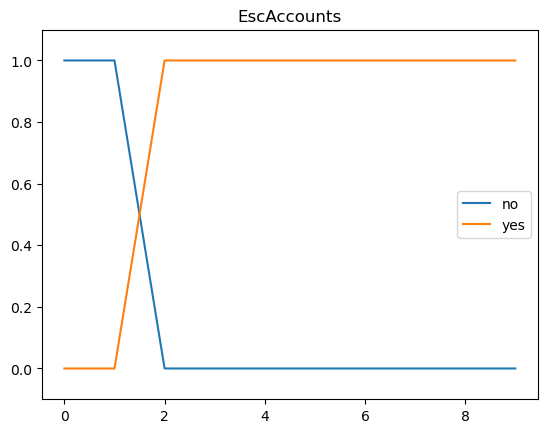

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


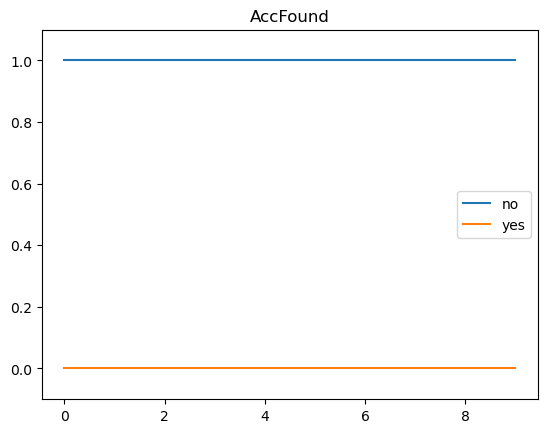

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


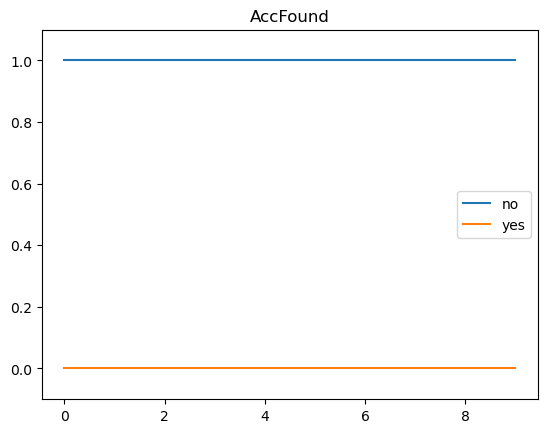

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.280000,0.720000
4,0.048730,0.951270
5,0.440994,0.559006
6,0.837613,0.162387
7,0.879489,0.120511
8,0.879722,0.120278
9,0.879722,0.120278


Plotting ('AccFound', ['no', 'yes']) for agent_j


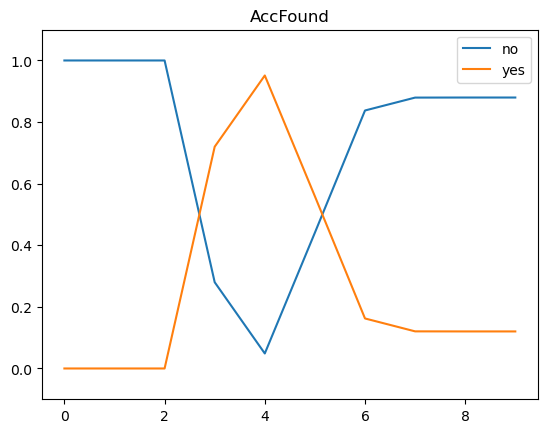

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


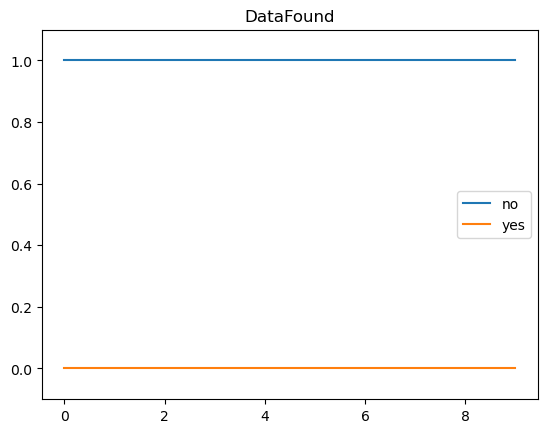

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.972973,0.027027
2,0.972973,0.027027
3,0.972973,0.027027
4,0.972973,0.027027
5,0.972973,0.027027
6,0.972973,0.027027
7,0.972973,0.027027
8,0.972973,0.027027
9,0.972973,0.027027


Plotting ('DataFound', ['no', 'yes']) for agent_i


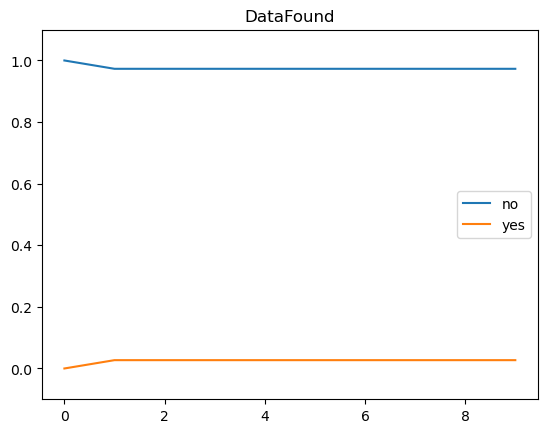

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_j


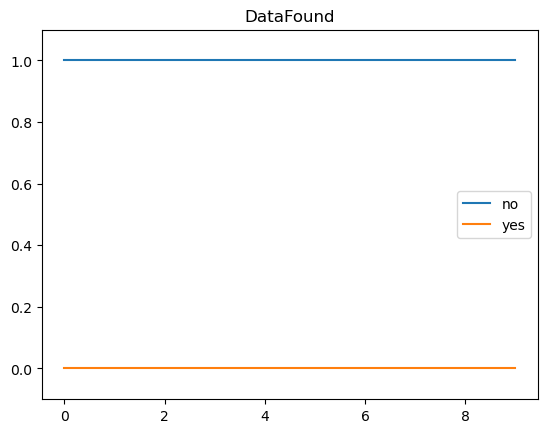

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


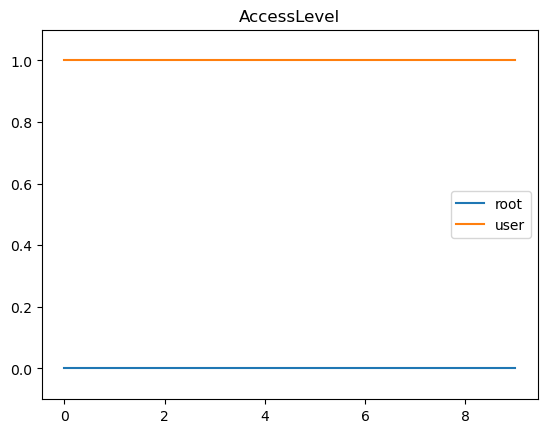

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


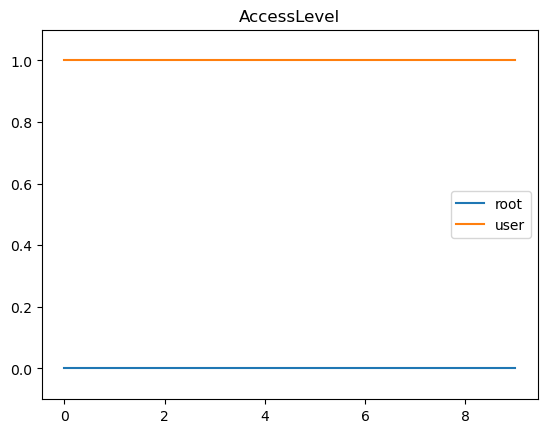

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.945093,0.054907
5,0.503106,0.496894
6,0.056211,0.943789
7,0.009027,0.990973
8,0.008764,0.991236
9,0.008764,0.991236


Plotting ('AccessLevel', ['root', 'user']) for agent_j


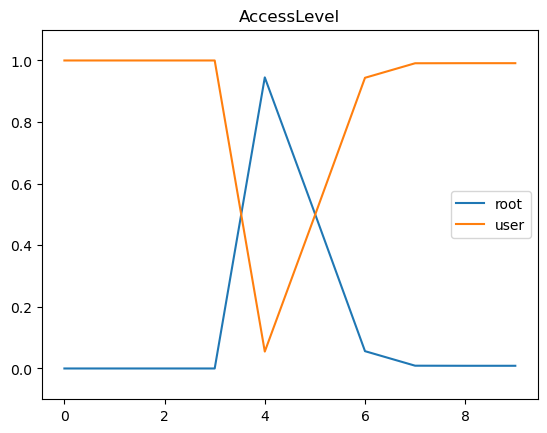

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


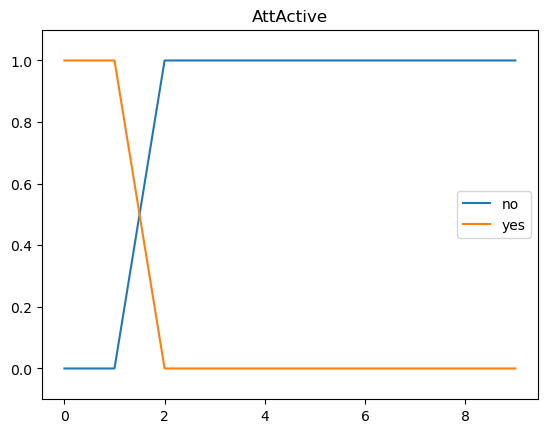

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


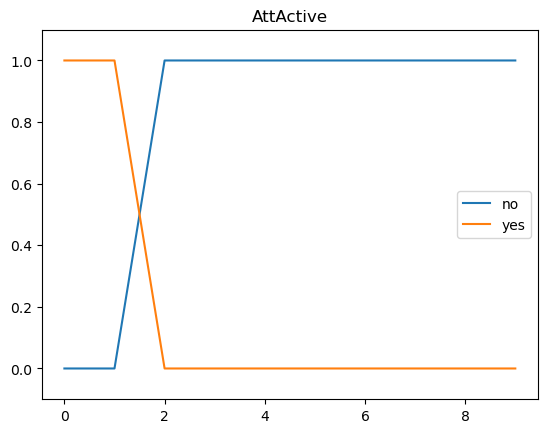

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.028655,0.971345
5,0.496894,0.503106
6,0.943789,0.056211
7,0.996875,0.003125
8,0.999984,0.000017
9,1.000000,0.000000


Plotting ('AttActive', ['no', 'yes']) for agent_j


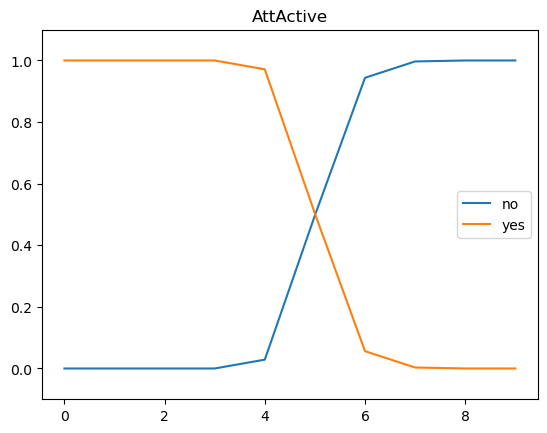

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


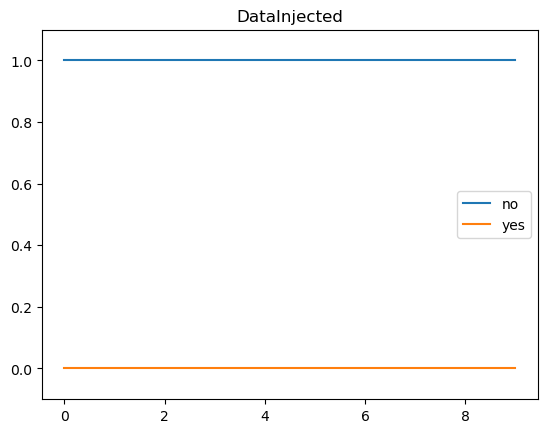

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


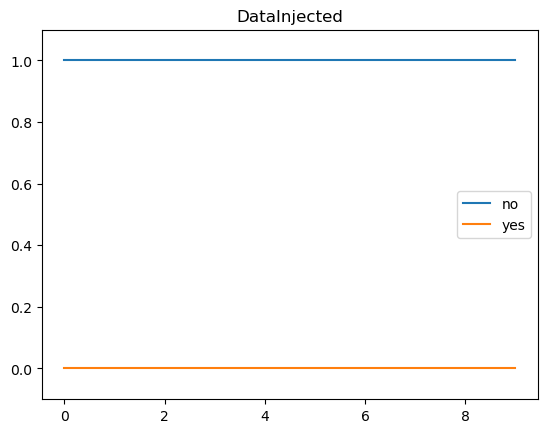

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_j


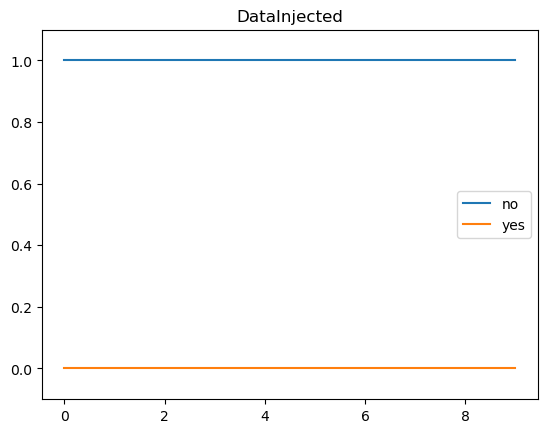

=============== End interaction trace


,highCap,lowCap
0,0.500000,0.500000
1,0.666667,0.333333
2,0.666667,0.333333
3,0.666667,0.333333
4,0.666667,0.333333
5,0.666667,0.333333
6,0.666667,0.333333
7,0.666667,0.333333
8,0.666667,0.333333
9,0.666667,0.333333


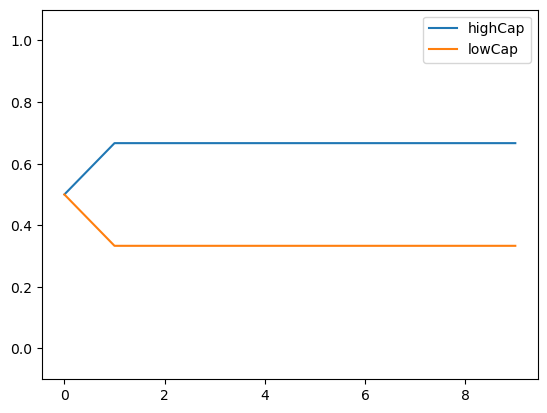

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


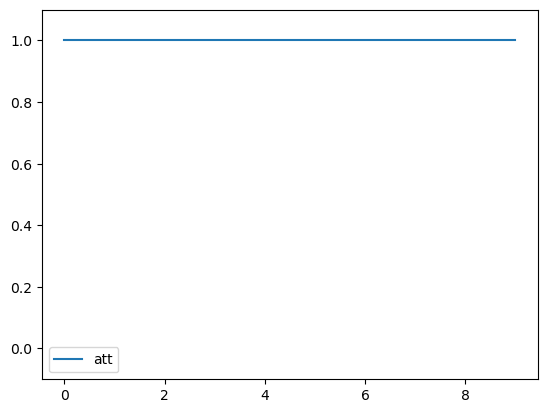

,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,FileRecon,denied|none|failure|active|perms_change,RestrictAccPrivs,file_enum
1,Exit,auth|none|failure|terminated|none,DecoyAccount,none
2,Nop,auth|user_files|failure|terminated|none,Nop,none
3,Nop,auth|none|failure|terminated|none,Nop,none
4,Nop,auth|user_files|failure|terminated|none,Nop,none
5,Nop,denied|user_files|success|terminated|none,Nop,none
6,Nop,denied|user_files|success|terminated|none,Nop,none
7,Nop,denied|none|failure|terminated|none,Nop,none
8,Nop,auth|user_files|success|terminated|none,Nop,none
9,Nop,denied|user_files|failure|terminated|none,Nop,file_enum


Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


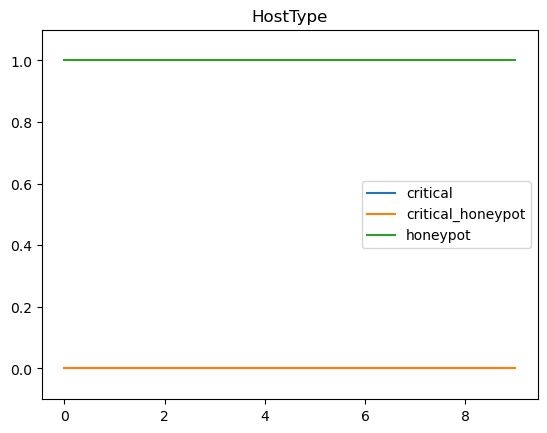

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


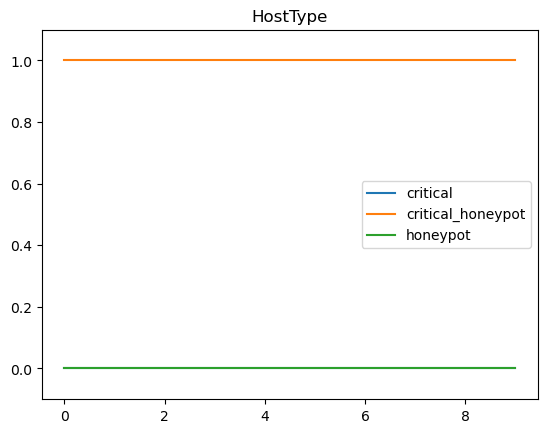

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


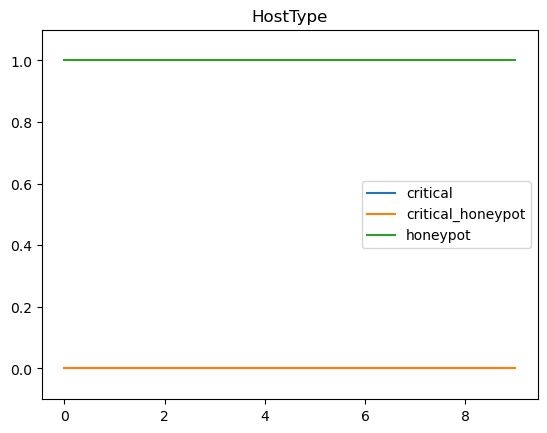

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for state:


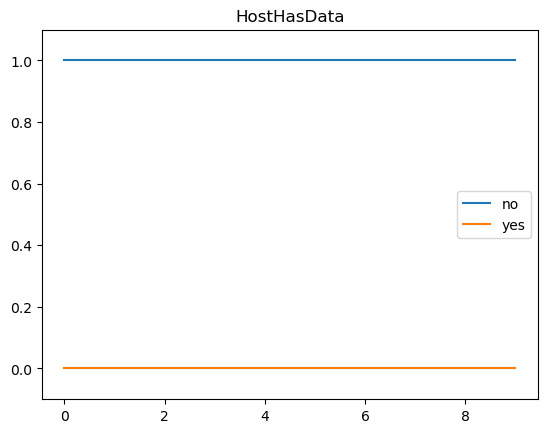

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.608108,0.391892
2,0.608108,0.391892
3,0.608108,0.391892
4,0.608108,0.391892
5,0.608108,0.391892
6,0.605625,0.394375
7,0.605625,0.394375
8,0.605625,0.394375
9,0.605625,0.394375


Plotting ('HostHasData', ['no', 'yes']) for agent_i


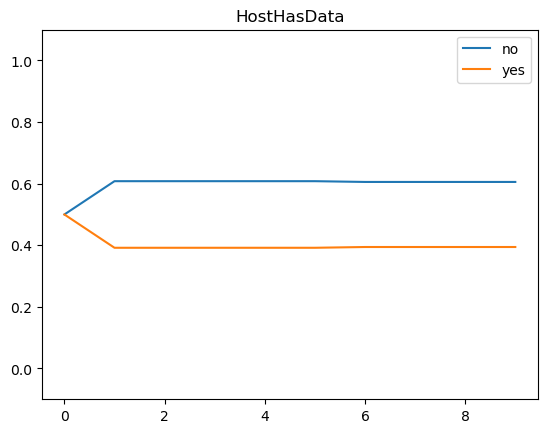

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


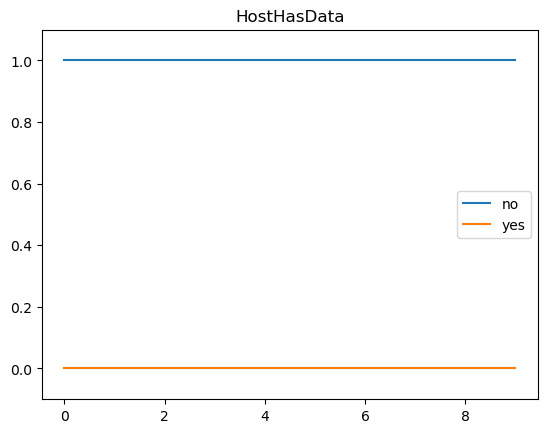

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


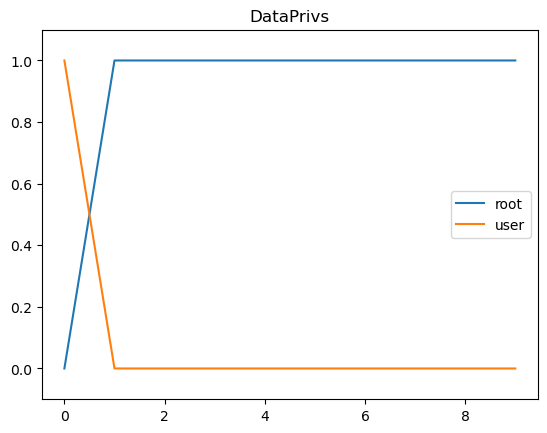

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.5,0.5
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_i


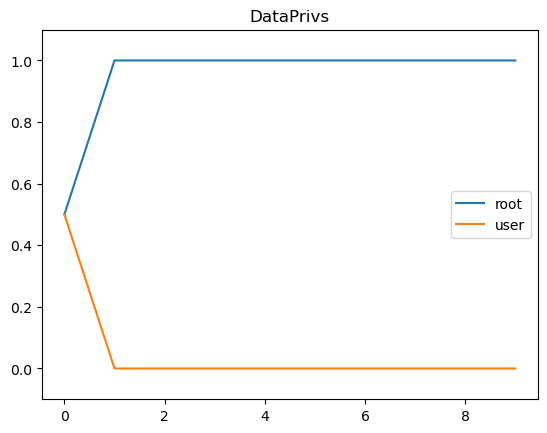

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


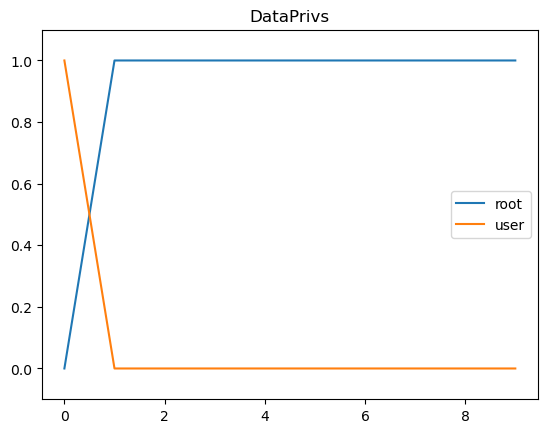

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


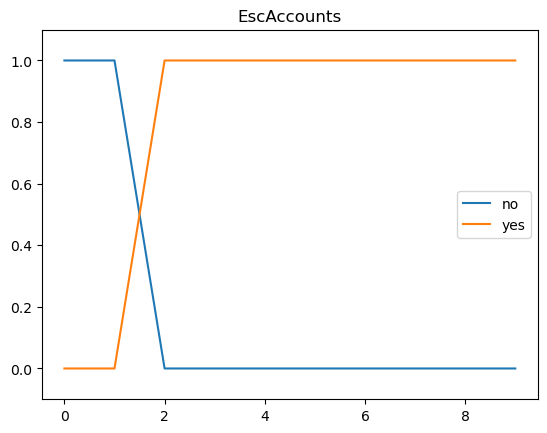

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


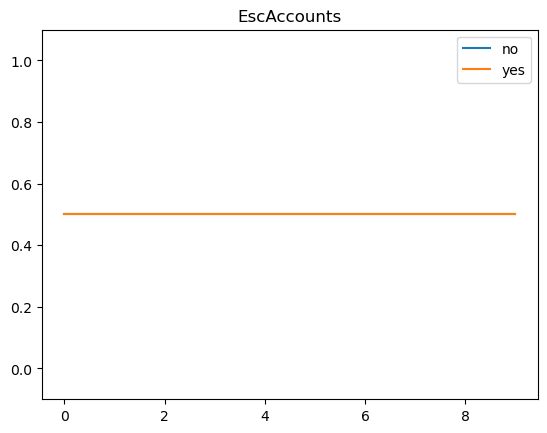

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


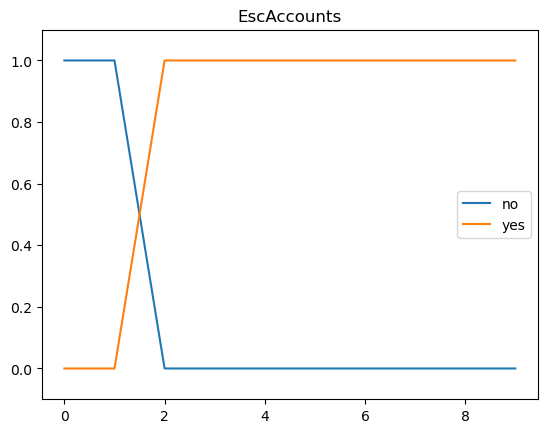

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


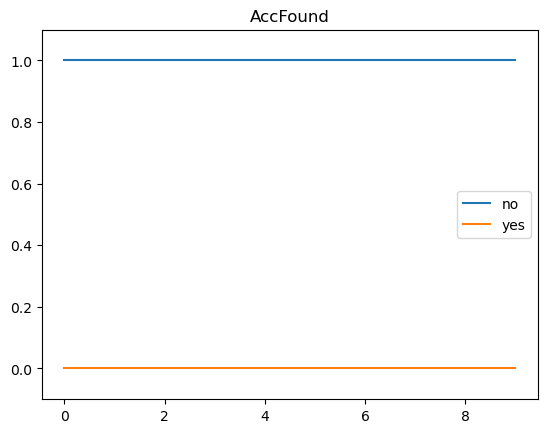

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


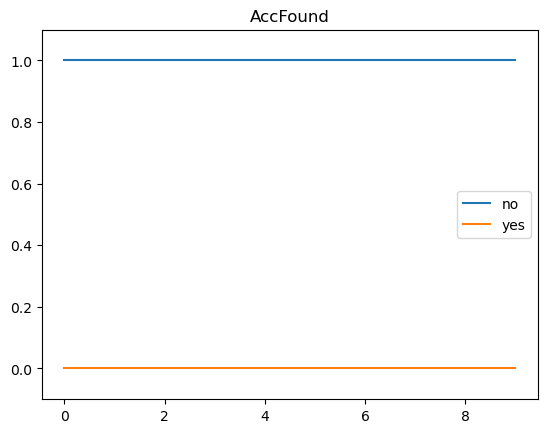

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.280000,0.720000
4,0.704918,0.295082
5,0.779893,0.220107
6,0.784803,0.215197
7,0.785065,0.214935
8,0.785066,0.214934
9,0.785067,0.214934


Plotting ('AccFound', ['no', 'yes']) for agent_j


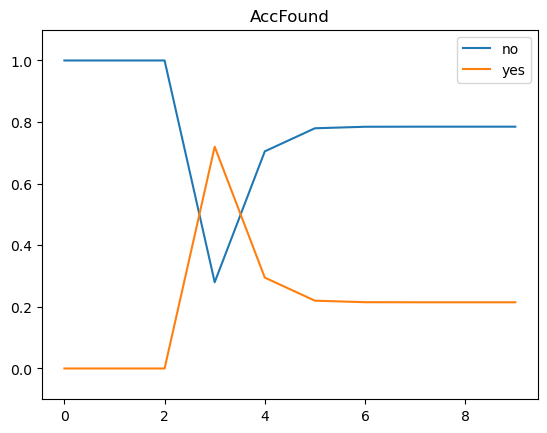

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


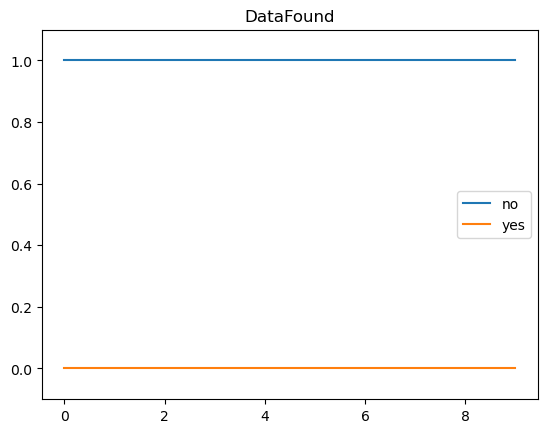

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.972973,0.027027
2,0.972973,0.027027
3,0.972973,0.027027
4,0.972973,0.027027
5,0.972973,0.027027
6,0.972973,0.027027
7,0.972973,0.027027
8,0.972973,0.027027
9,0.972973,0.027027


Plotting ('DataFound', ['no', 'yes']) for agent_i


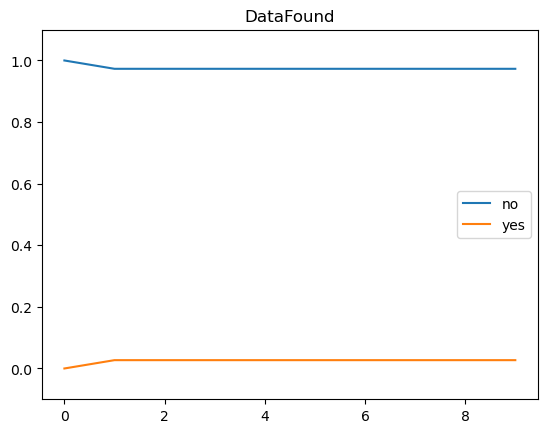

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_j


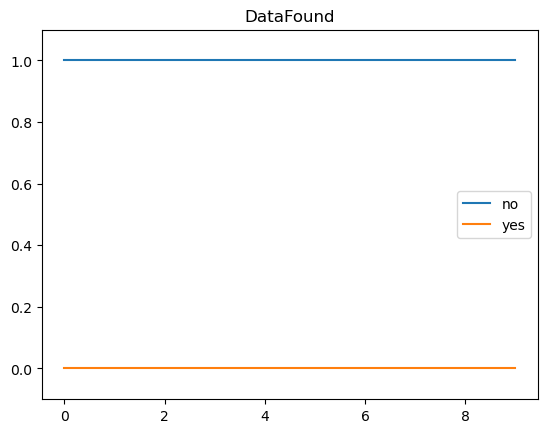

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


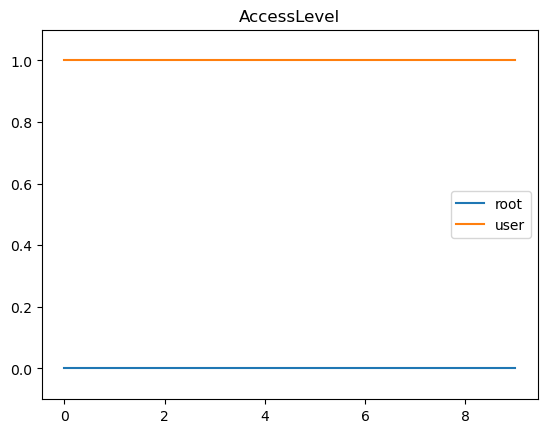

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


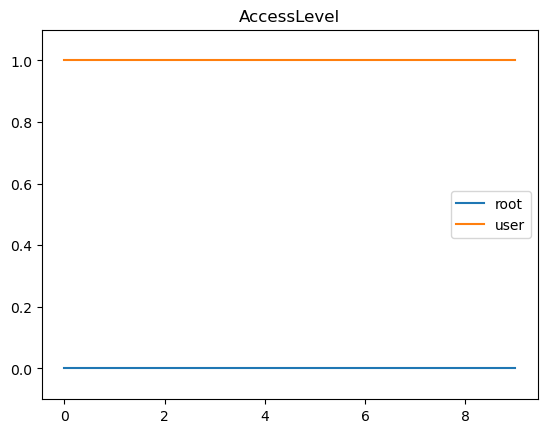

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.102144,0.897856
5,0.006648,0.993353
6,0.000393,0.999606
7,0.000060,0.999940
8,0.000058,0.999942
9,0.000058,0.999942


Plotting ('AccessLevel', ['root', 'user']) for agent_j


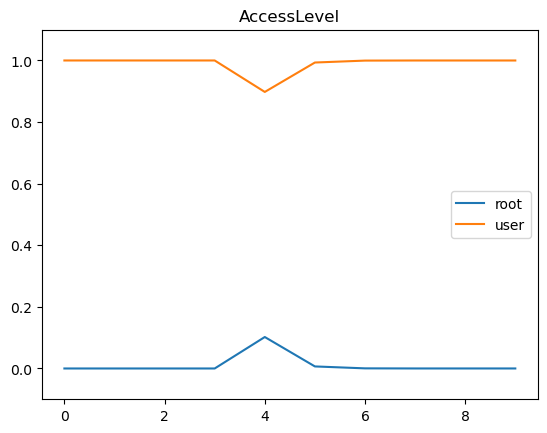

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


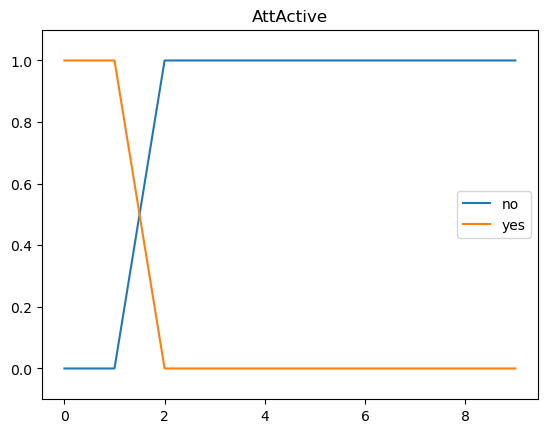

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


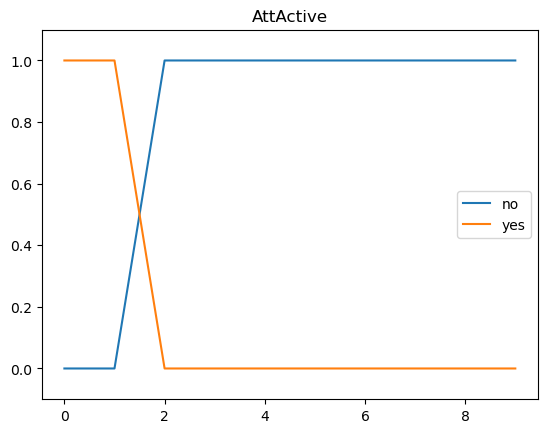

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,9.999999e-01
2,0.000000,1.000000e+00
3,0.000000,1.000000e+00
4,0.895019,1.049811e-01
5,0.993353,6.647518e-03
6,0.999606,3.934923e-04
7,0.999979,2.083889e-05
8,1.000000,1.103237e-07
9,1.000000,0.000000e+00


Plotting ('AttActive', ['no', 'yes']) for agent_j


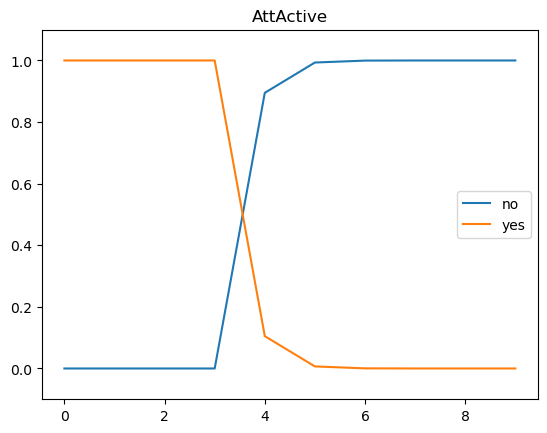

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


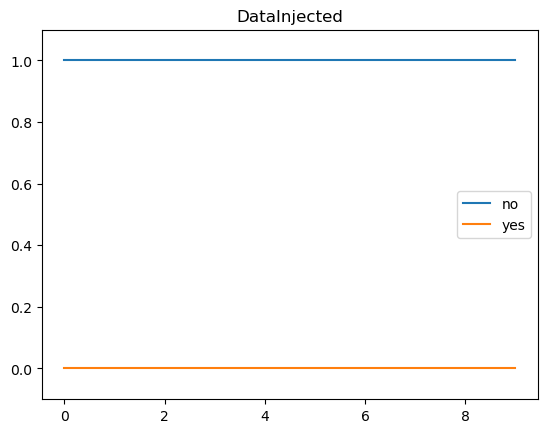

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


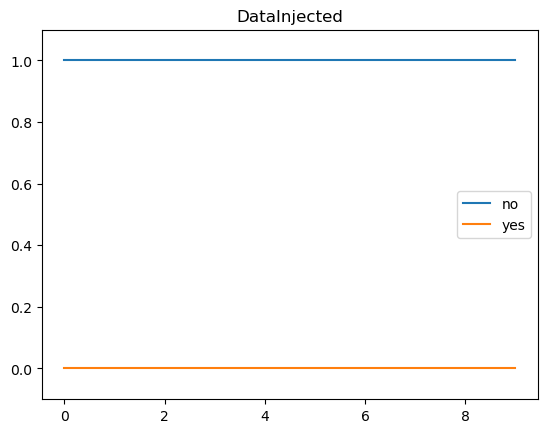

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_j


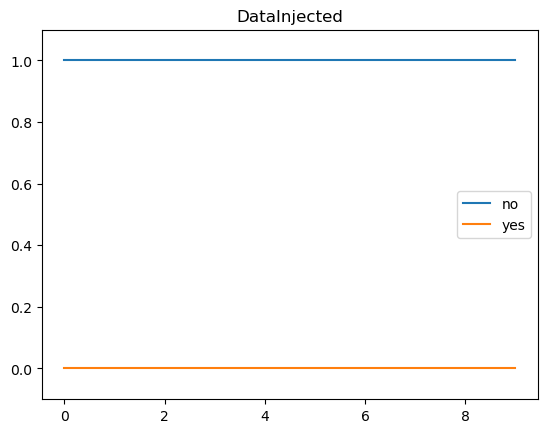

=============== End interaction trace


,highCap,lowCap
0,0.500000,0.500000
1,0.666667,0.333333
2,0.666667,0.333333
3,0.666667,0.333333
4,0.666667,0.333333
5,0.666667,0.333333
6,0.666667,0.333333
7,0.666667,0.333333
8,0.666667,0.333333
9,0.666667,0.333333


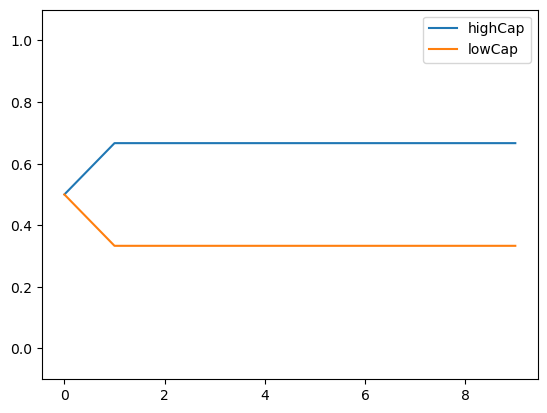

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


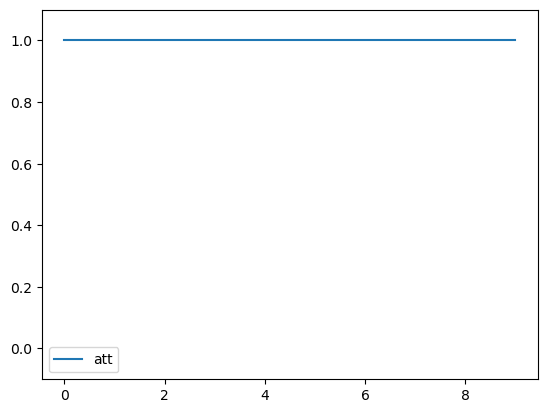

,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,FileRecon,denied|none|failure|active|perms_change,RestrictAccPrivs,file_enum
1,Exit,denied|user_files|success|terminated|none,DecoyAccount,none
2,Nop,auth|user_files|success|terminated|none,Nop,none
3,Nop,denied|none|success|terminated|none,Nop,none
4,Nop,denied|user_files|success|terminated|none,Nop,none
5,Nop,denied|none|success|terminated|none,Nop,none
6,Nop,denied|none|failure|terminated|none,Nop,file_enum
7,Nop,denied|user_files|success|terminated|none,Nop,none
8,Nop,auth|user_files|success|terminated|none,Nop,none
9,Nop,auth|none|success|terminated|none,Nop,none


Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


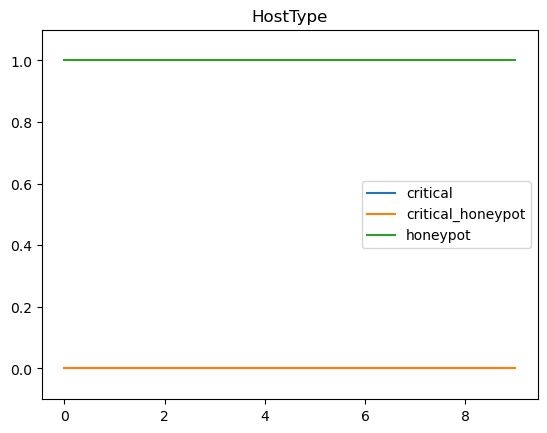

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


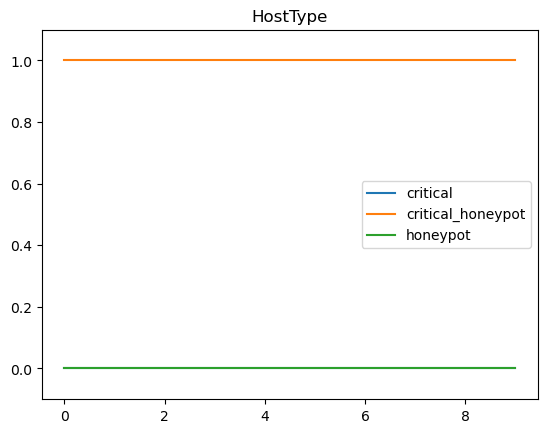

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


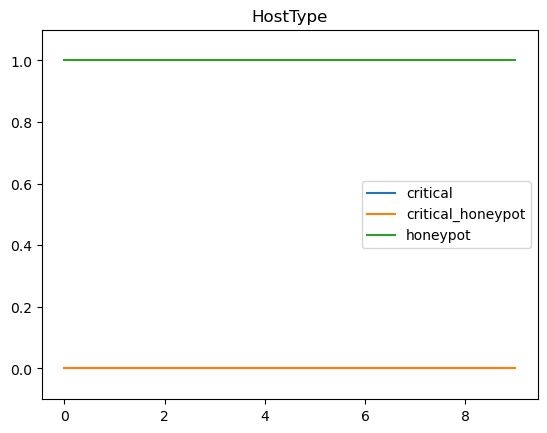

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for state:


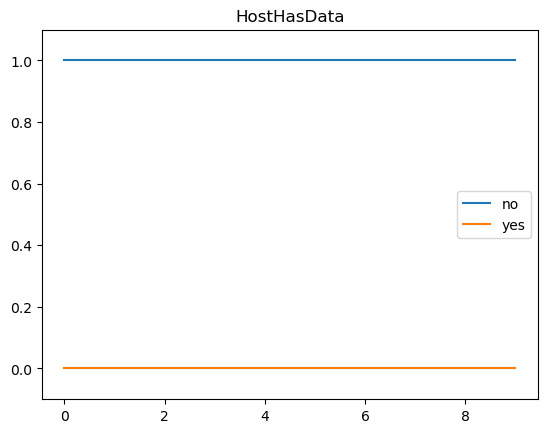

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.608108,0.391892
2,0.608108,0.391892
3,0.608108,0.391892
4,0.608108,0.391892
5,0.608108,0.391892
6,0.605625,0.394375
7,0.605625,0.394375
8,0.605625,0.394375
9,0.605625,0.394375


Plotting ('HostHasData', ['no', 'yes']) for agent_i


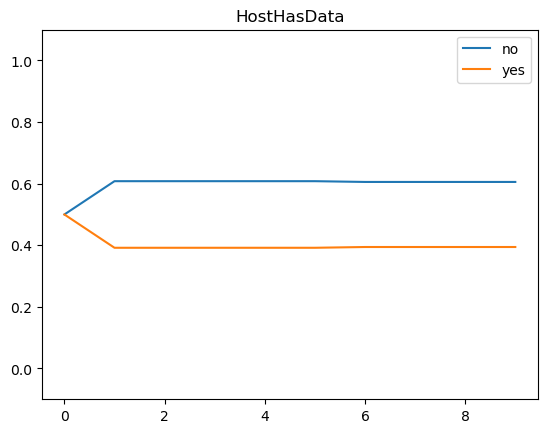

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


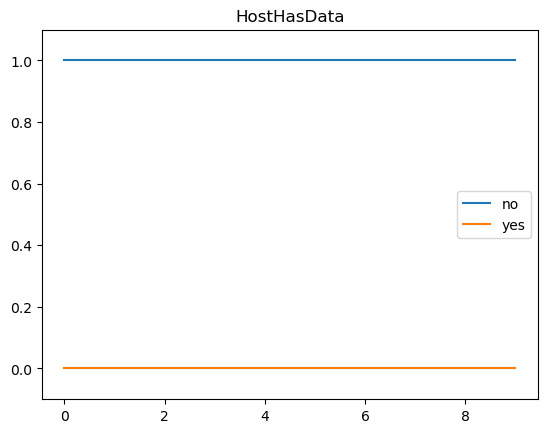

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


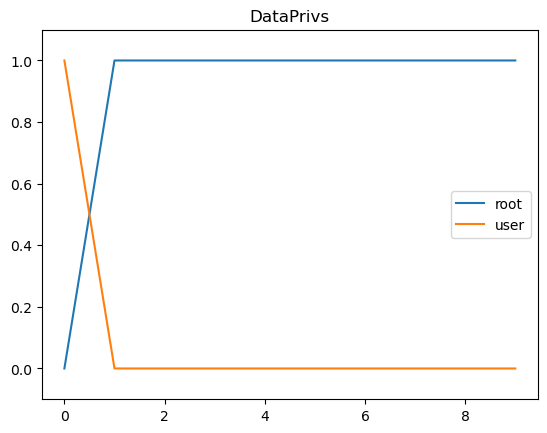

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.5,0.5
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_i


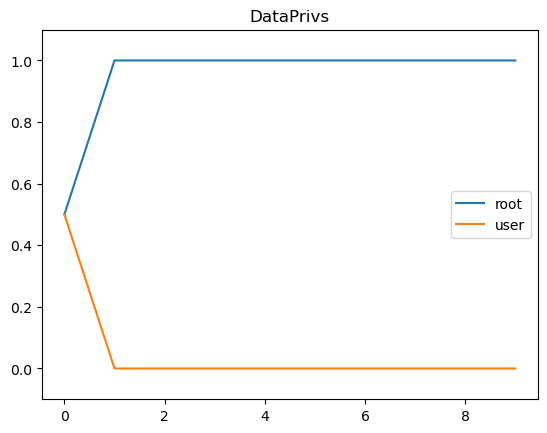

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


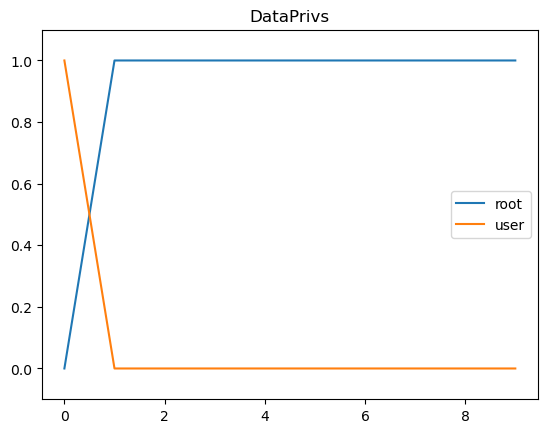

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


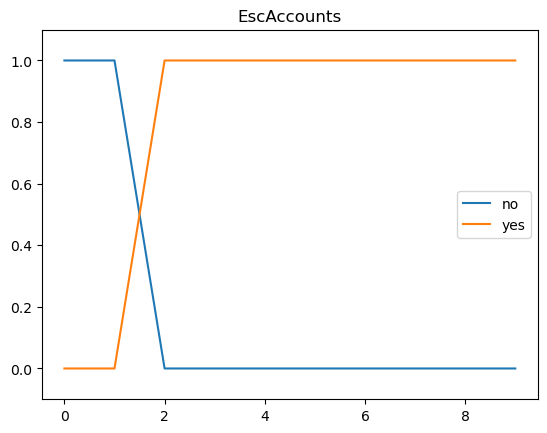

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


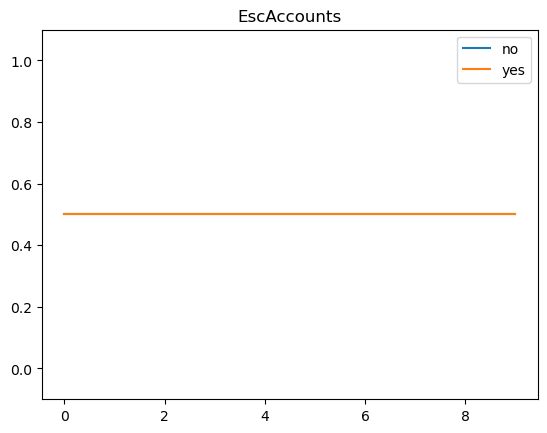

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


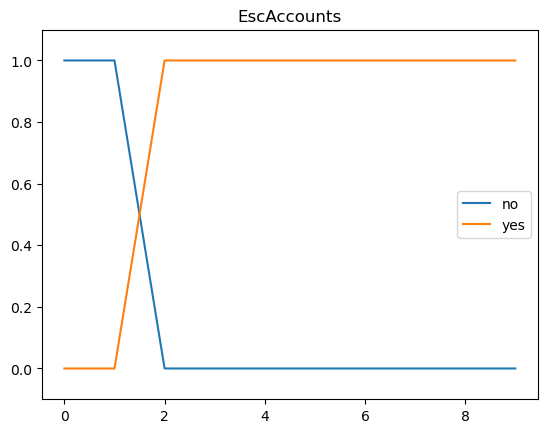

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


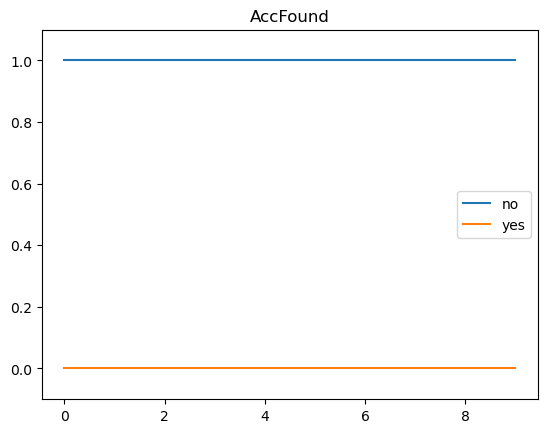

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


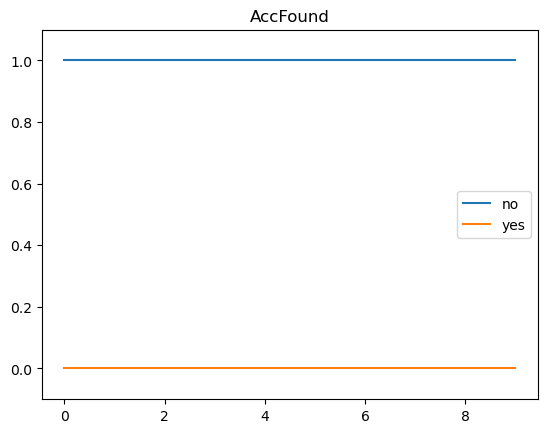

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.280000,0.720000
4,0.704918,0.295082
5,0.779893,0.220107
6,0.784803,0.215197
7,0.780821,0.219179
8,0.781218,0.218782
9,0.781218,0.218782


Plotting ('AccFound', ['no', 'yes']) for agent_j


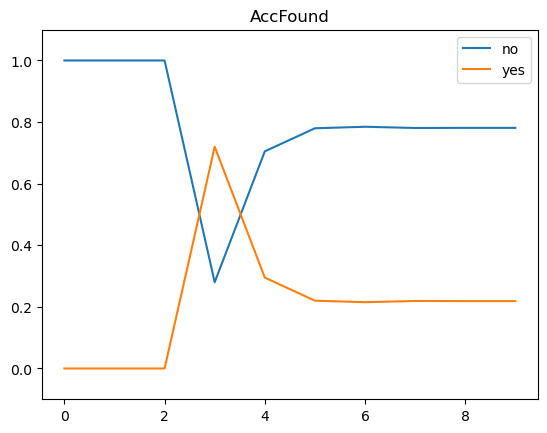

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


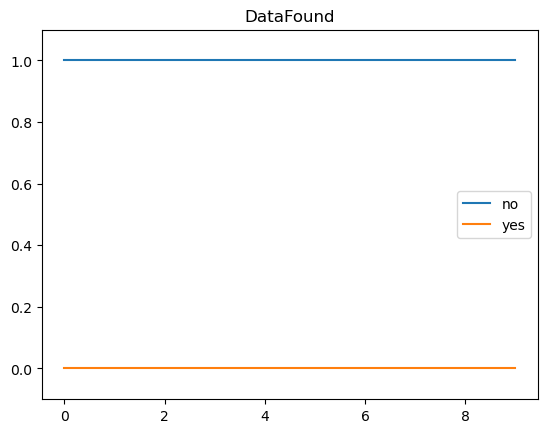

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.972973,0.027027
2,0.972973,0.027027
3,0.972973,0.027027
4,0.972973,0.027027
5,0.972973,0.027027
6,0.972973,0.027027
7,0.972973,0.027027
8,0.972973,0.027027
9,0.972973,0.027027


Plotting ('DataFound', ['no', 'yes']) for agent_i


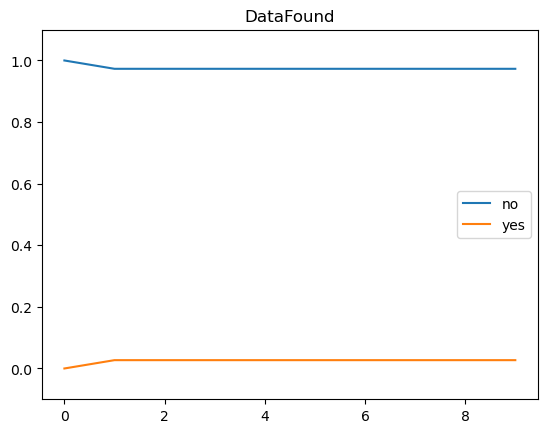

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_j


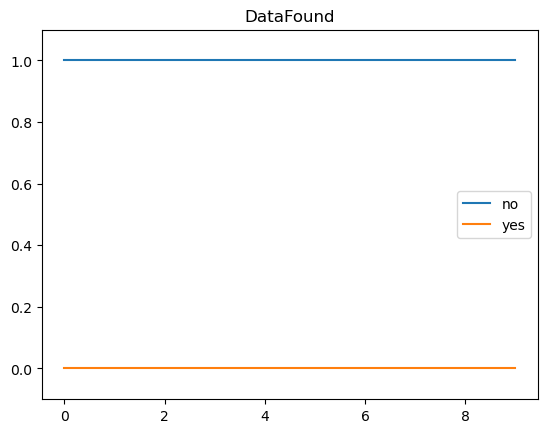

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


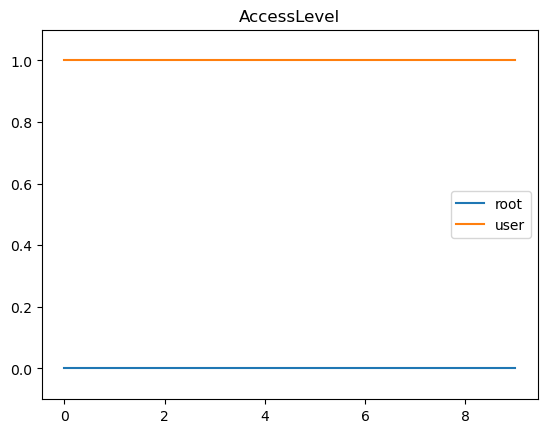

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


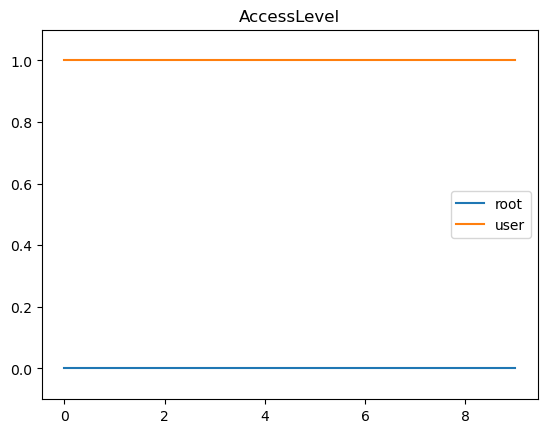

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.102144,0.897856
5,0.006648,0.993353
6,0.000393,0.999606
7,0.005465,0.994535
8,0.004960,0.995040
9,0.004960,0.995040


Plotting ('AccessLevel', ['root', 'user']) for agent_j


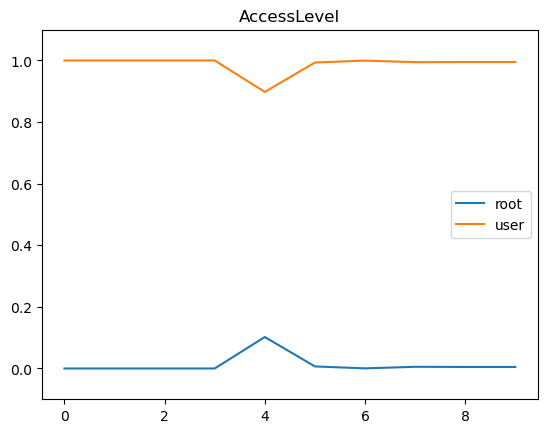

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


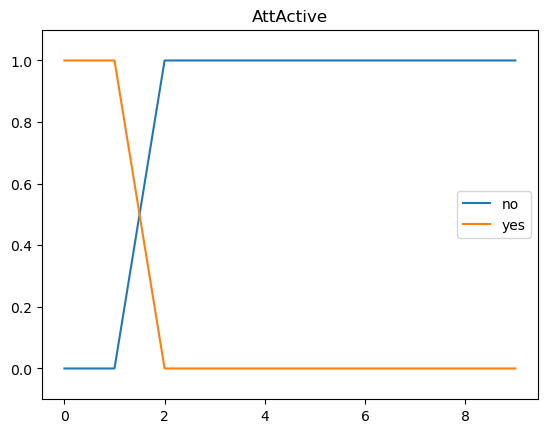

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


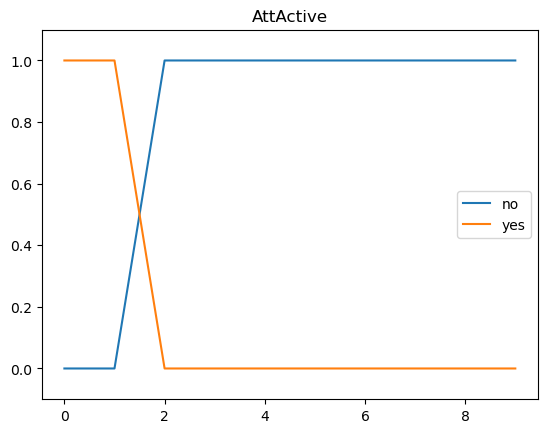

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.895019,0.104981
5,0.993353,0.006648
6,0.999606,0.000393
7,0.994574,0.005426
8,0.999968,0.000032
9,1.000000,0.000000


Plotting ('AttActive', ['no', 'yes']) for agent_j


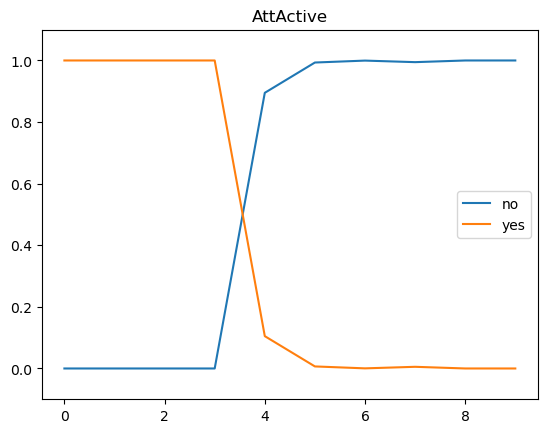

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


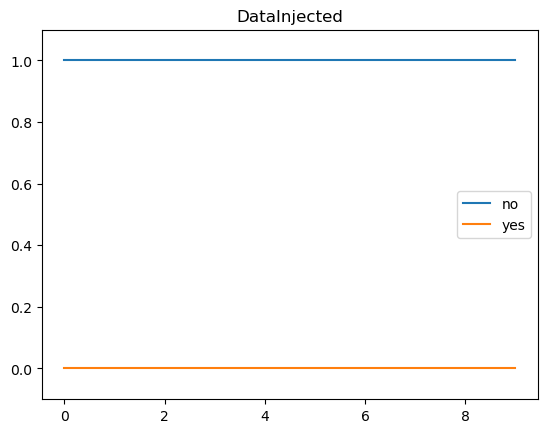

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


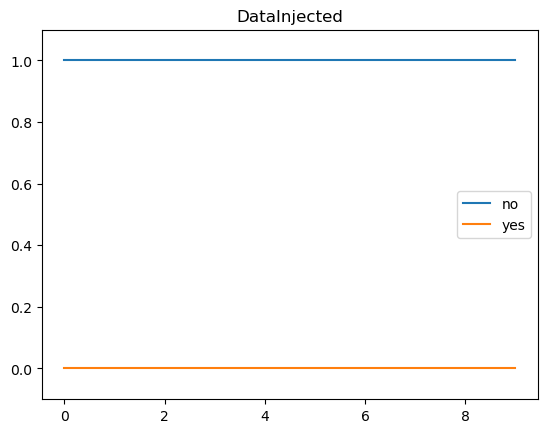

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_j


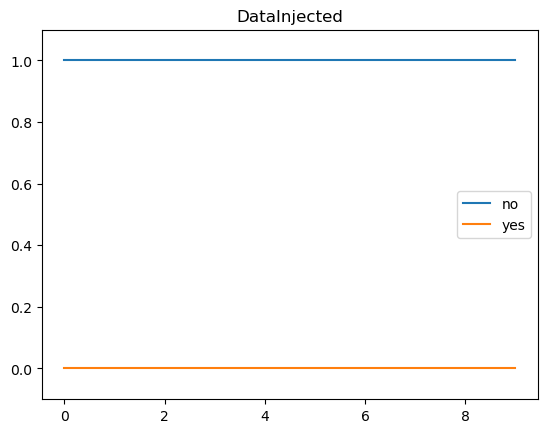

=============== End interaction trace


,highCap,lowCap
0,0.500000,0.500000
1,0.666667,0.333333
2,0.666667,0.333333
3,0.666667,0.333333
4,0.666667,0.333333
5,0.666667,0.333333
6,0.666667,0.333333
7,0.666667,0.333333
8,0.666667,0.333333
9,0.666667,0.333333


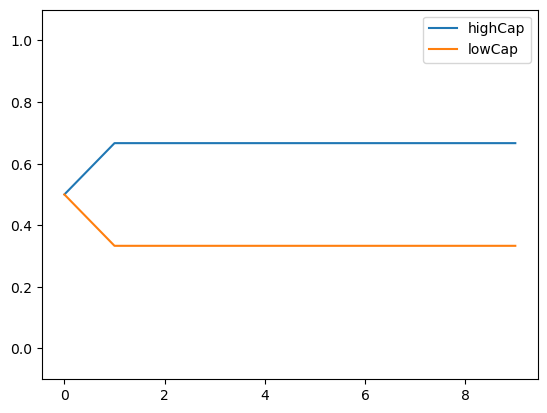

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


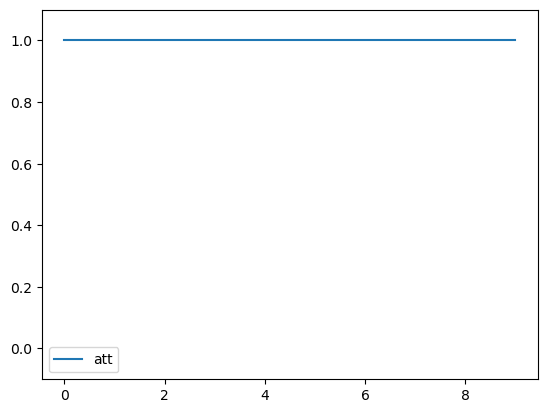

,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,FileRecon,denied|none|failure|active|perms_change,RestrictAccPrivs,file_enum
1,Exit,denied|user_files|failure|terminated|none,DecoyAccount,login_activity
2,Nop,denied|user_files|failure|terminated|none,Nop,none
3,Nop,auth|user_files|success|terminated|none,Nop,none
4,Nop,auth|none|success|terminated|none,Nop,login_activity
5,Nop,denied|user_files|success|terminated|none,Nop,none
6,Nop,auth|user_files|failure|terminated|none,Nop,none
7,Nop,denied|user_files|success|terminated|none,Nop,none
8,Nop,denied|user_files|success|terminated|none,Nop,none
9,Nop,auth|user_files|failure|terminated|none,Nop,none


Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


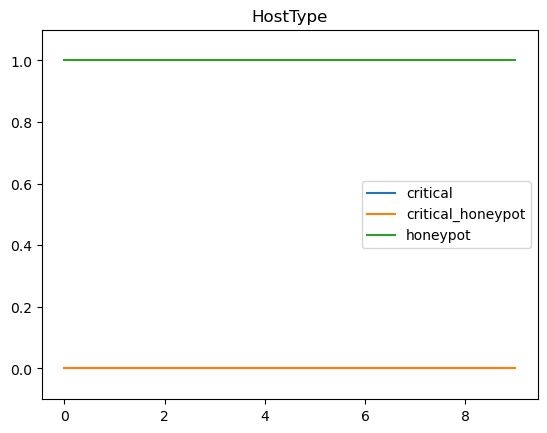

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


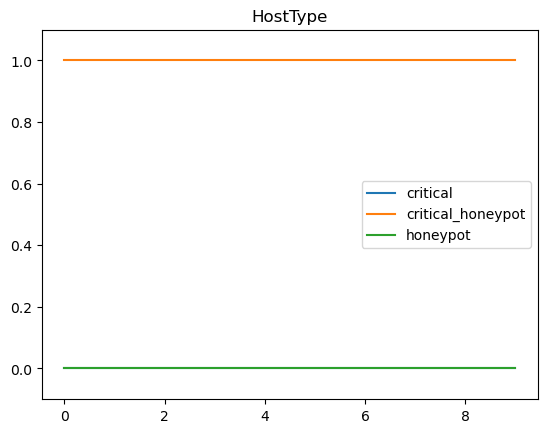

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


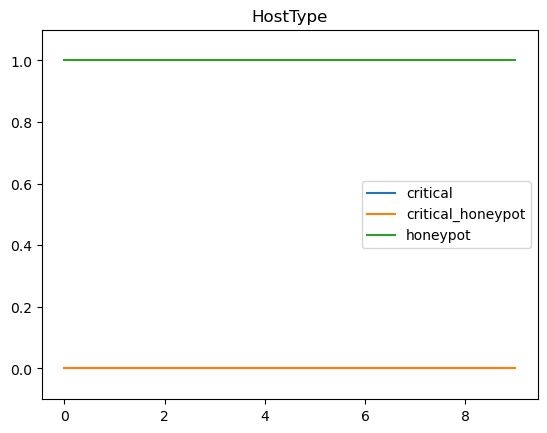

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for state:


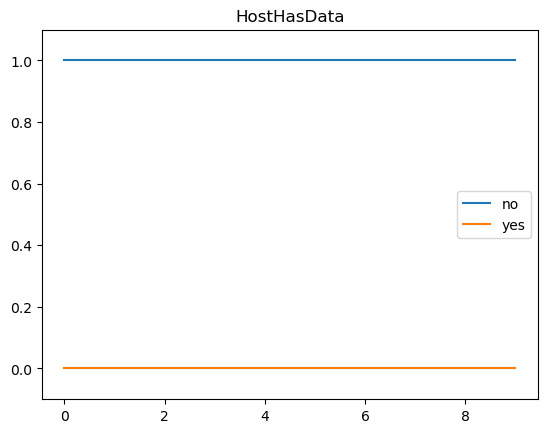

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.608108,0.391892
2,0.608108,0.391892
3,0.608108,0.391892
4,0.608108,0.391892
5,0.608108,0.391892
6,0.605625,0.394375
7,0.605625,0.394375
8,0.605625,0.394375
9,0.605625,0.394375


Plotting ('HostHasData', ['no', 'yes']) for agent_i


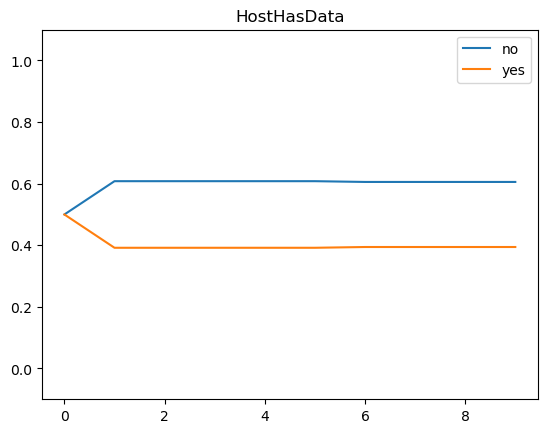

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


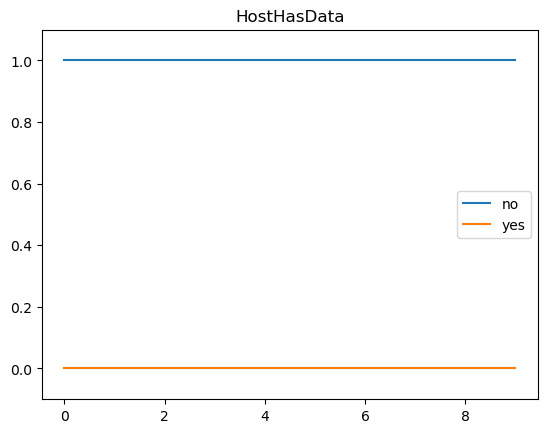

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


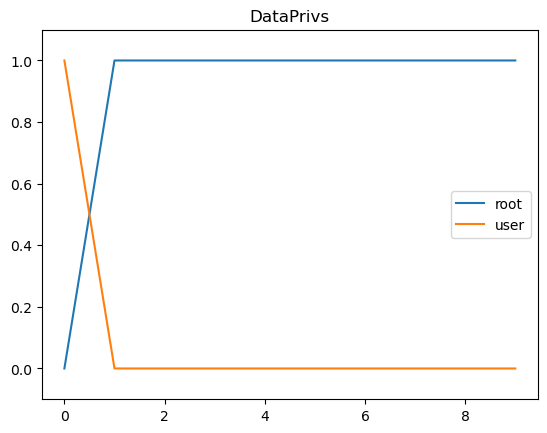

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.5,0.5
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_i


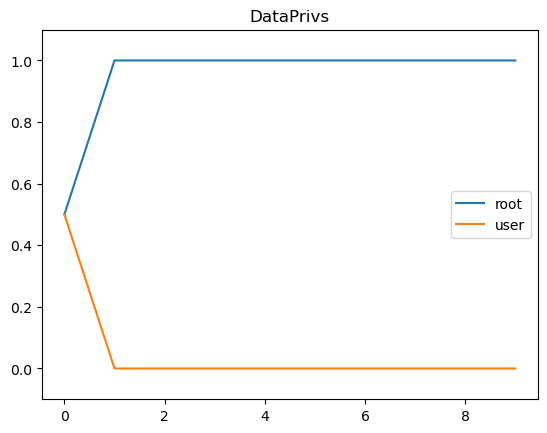

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


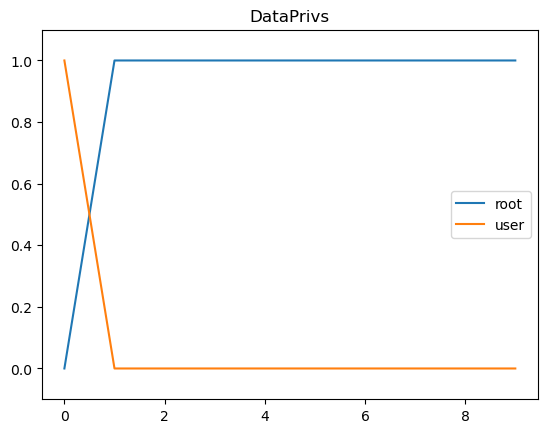

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


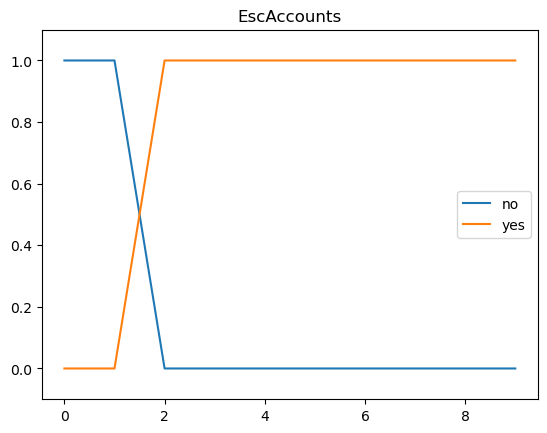

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


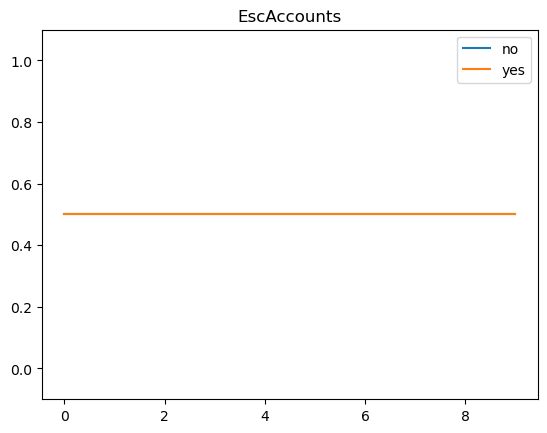

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


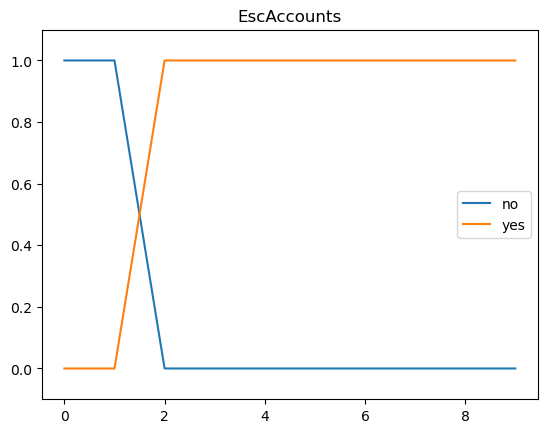

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


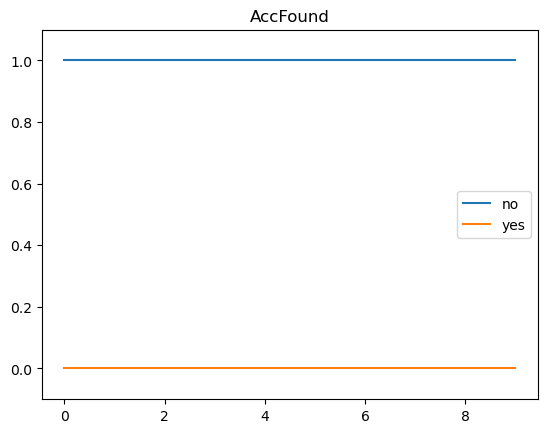

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


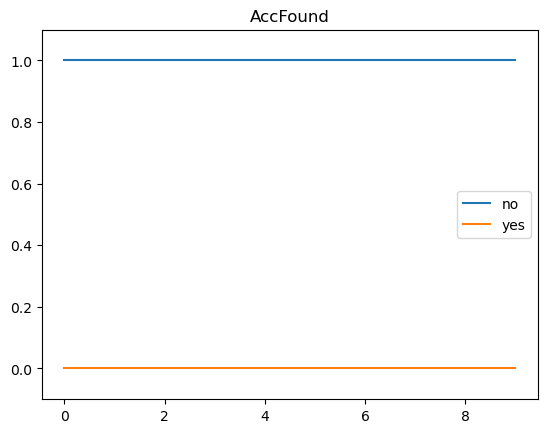

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.280000,0.720000
4,0.704918,0.295082
5,0.704918,0.295082
6,0.779893,0.220107
7,0.784310,0.215690
8,0.784333,0.215667
9,0.784333,0.215667


Plotting ('AccFound', ['no', 'yes']) for agent_j


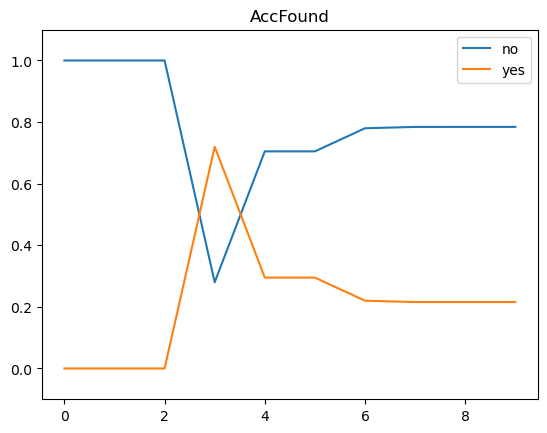

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


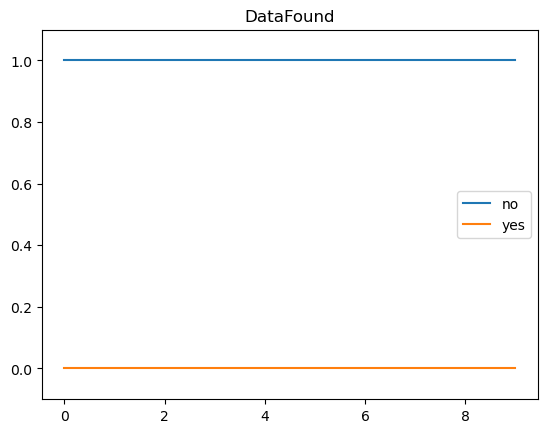

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.972973,0.027027
2,0.972973,0.027027
3,0.972973,0.027027
4,0.972973,0.027027
5,0.972973,0.027027
6,0.972973,0.027027
7,0.972973,0.027027
8,0.972973,0.027027
9,0.972973,0.027027


Plotting ('DataFound', ['no', 'yes']) for agent_i


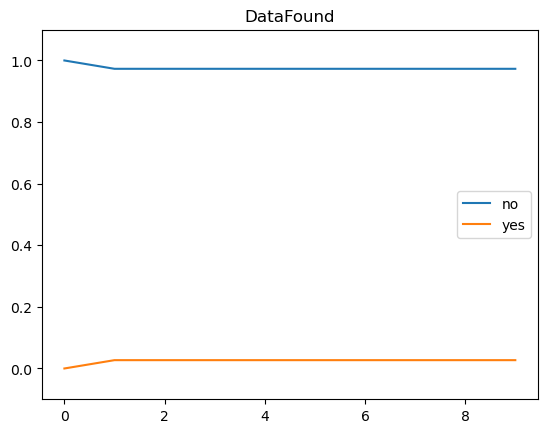

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_j


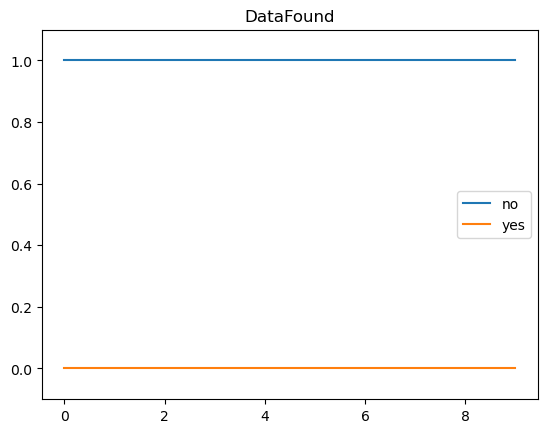

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


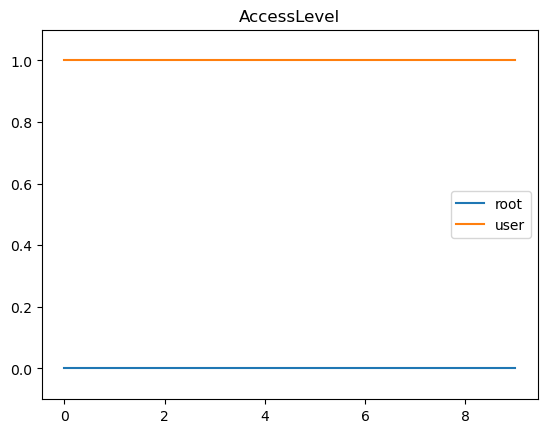

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


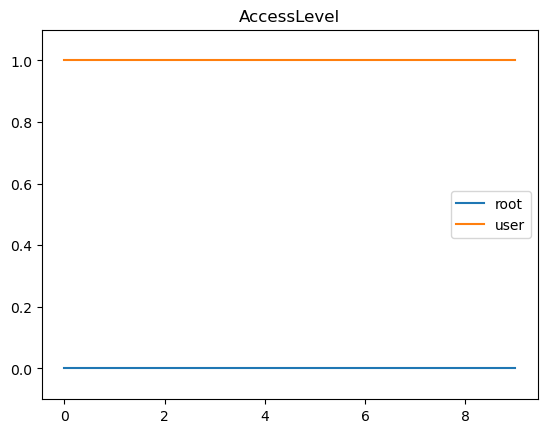

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.102144,0.897856
5,0.102144,0.897856
6,0.006648,0.993352
7,0.001022,0.998977
8,0.000992,0.999008
9,0.000992,0.999007


Plotting ('AccessLevel', ['root', 'user']) for agent_j


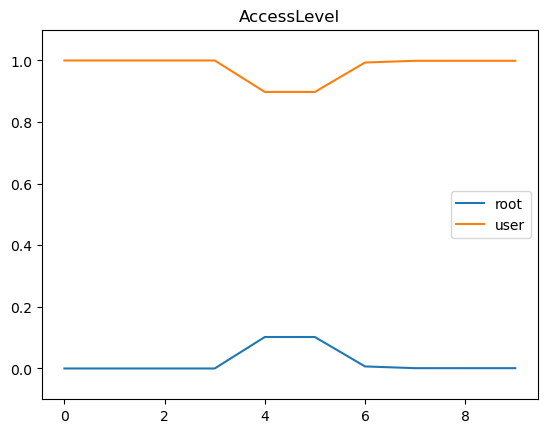

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


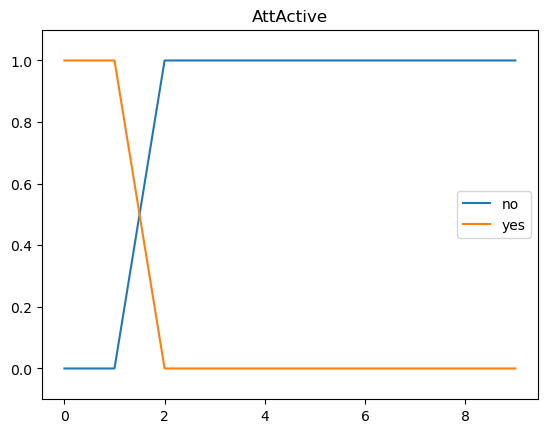

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


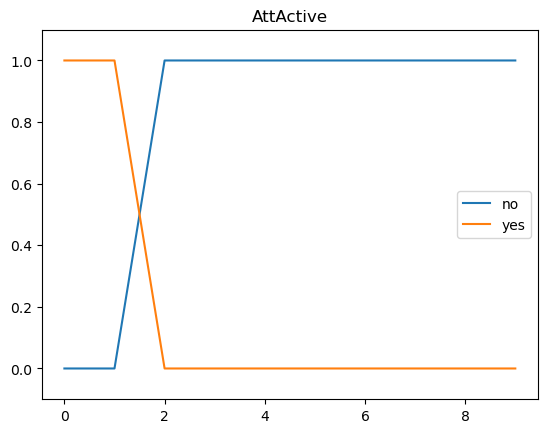

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.895019,0.104981
5,0.897856,0.102144
6,0.993352,0.006648
7,0.999646,0.000354
8,0.999998,0.000002
9,1.000000,0.000000


Plotting ('AttActive', ['no', 'yes']) for agent_j


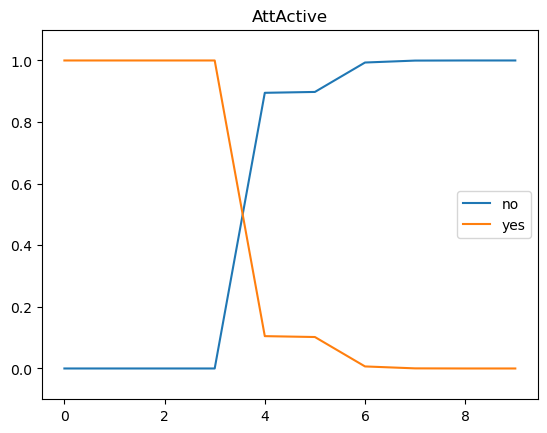

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


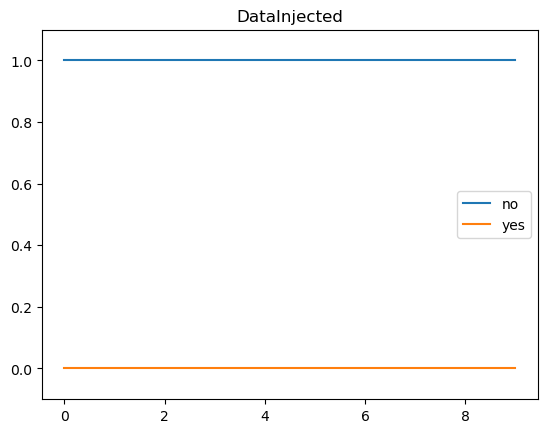

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


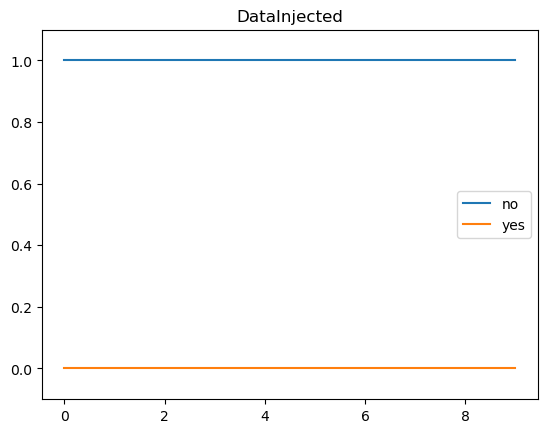

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_j


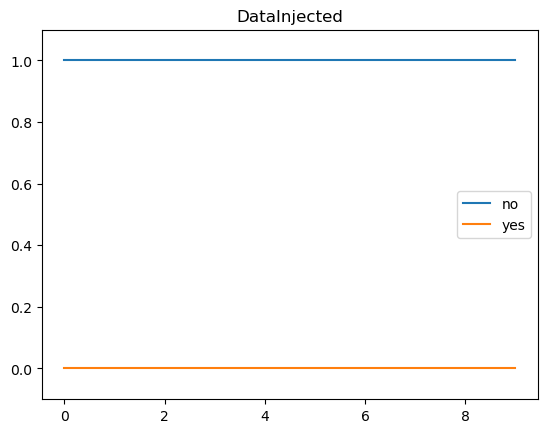

=============== End interaction trace


,highCap,lowCap
0,0.500000,0.500000
1,0.666667,0.333333
2,0.666667,0.333333
3,0.666667,0.333333
4,0.666667,0.333333
5,0.666667,0.333333
6,0.666667,0.333333
7,0.666667,0.333333
8,0.666667,0.333333
9,0.666667,0.333333


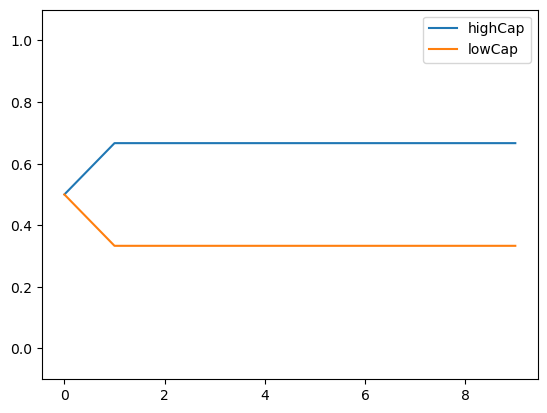

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


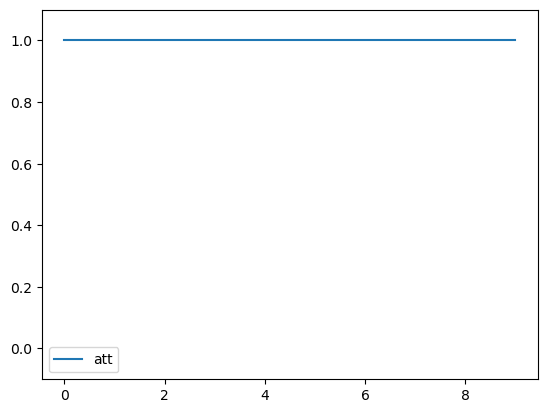

,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,FileRecon,denied|none|failure|active|acc_policy_change,RestrictAccPrivs,file_enum
1,Exit,auth|user_files|failure|terminated|none,DecoyAccount,none
2,Nop,auth|none|failure|terminated|none,Nop,none
3,Nop,denied|none|failure|terminated|none,Nop,none
4,Nop,auth|user_files|success|terminated|none,Nop,login_activity
5,Nop,denied|user_files|failure|terminated|none,Nop,none
6,Nop,denied|none|failure|terminated|none,Nop,none
7,Nop,denied|user_files|failure|terminated|none,Nop,none
8,Nop,denied|none|failure|terminated|none,Nop,none
9,Nop,denied|none|success|terminated|none,Nop,none


Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


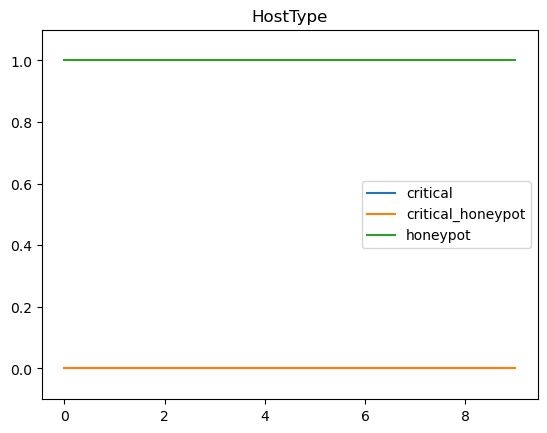

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


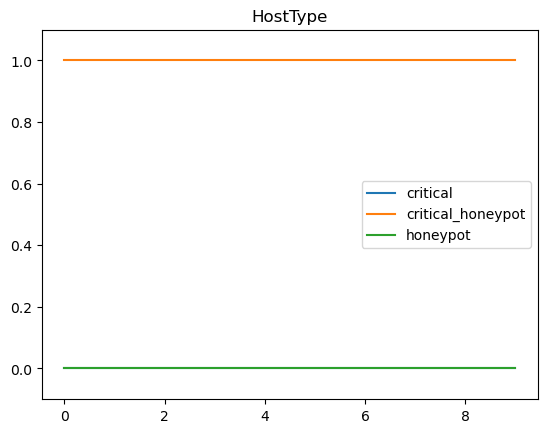

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


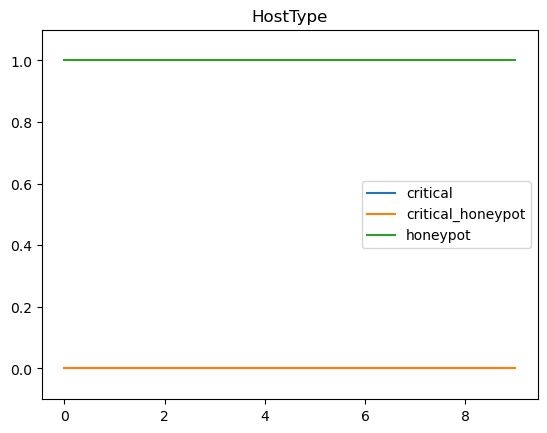

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for state:


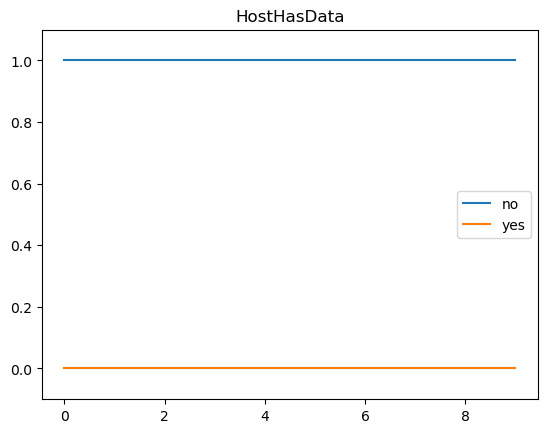

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.608108,0.391892
2,0.608108,0.391892
3,0.608108,0.391892
4,0.608108,0.391892
5,0.608108,0.391892
6,0.605625,0.394375
7,0.605625,0.394375
8,0.605625,0.394375
9,0.605625,0.394375


Plotting ('HostHasData', ['no', 'yes']) for agent_i


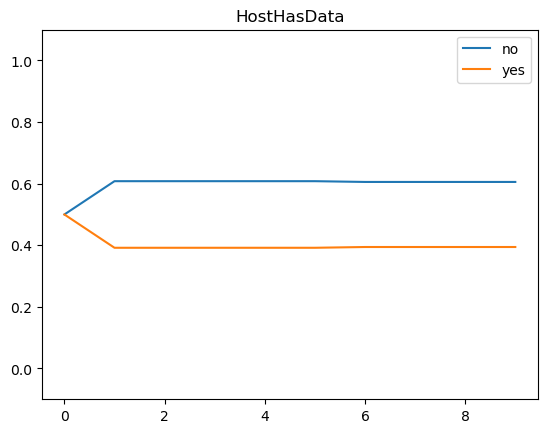

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


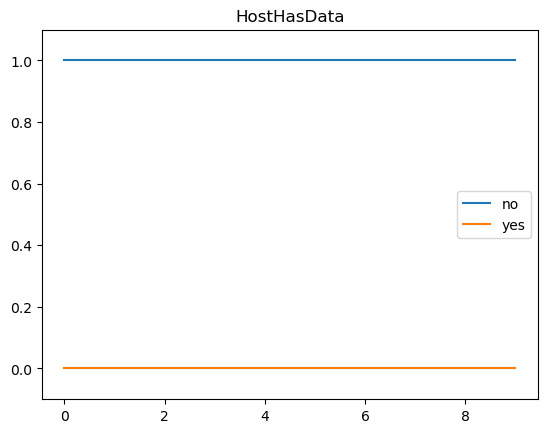

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


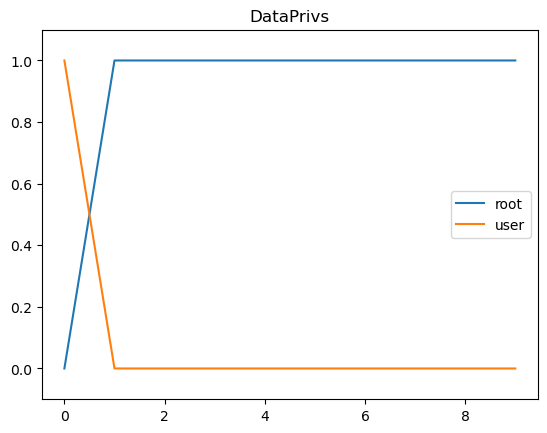

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.5,0.5
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_i


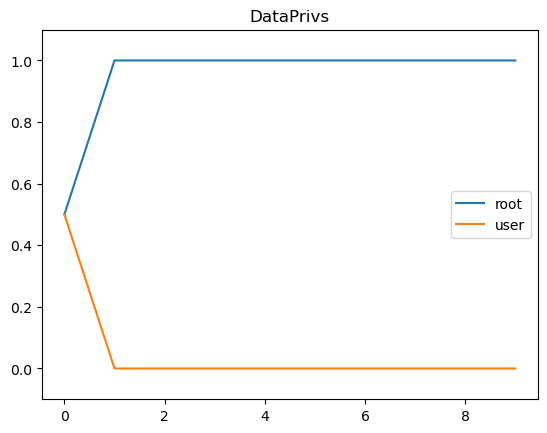

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


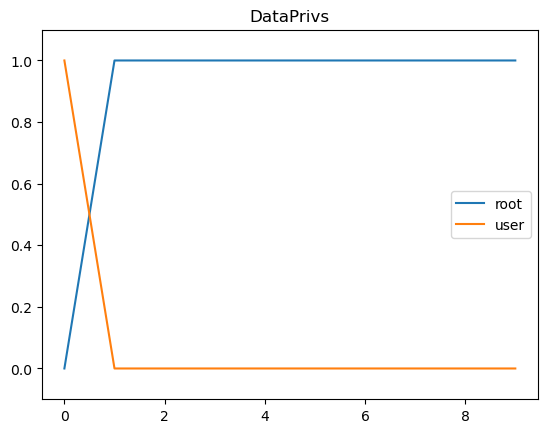

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


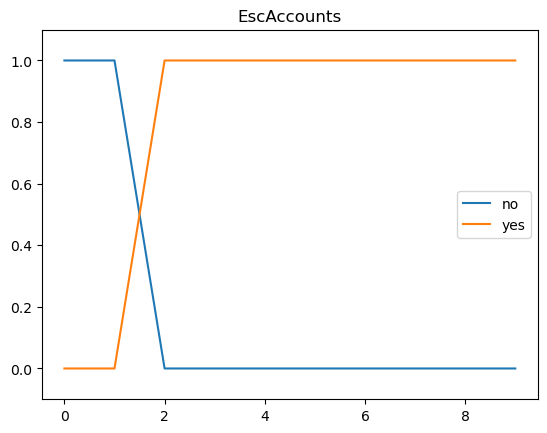

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


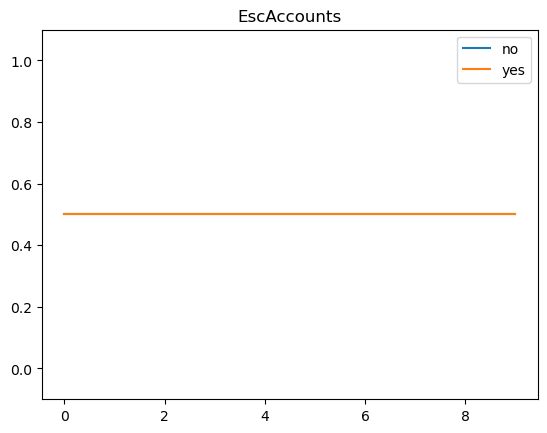

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


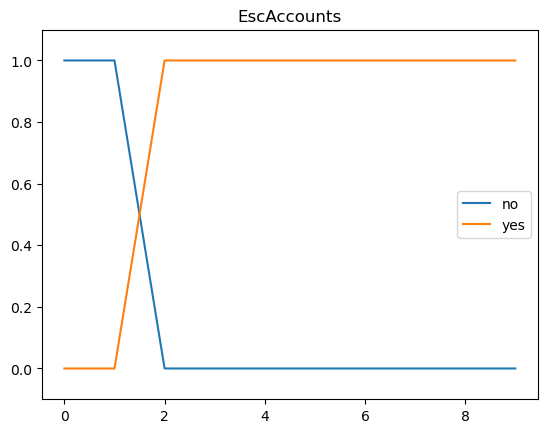

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


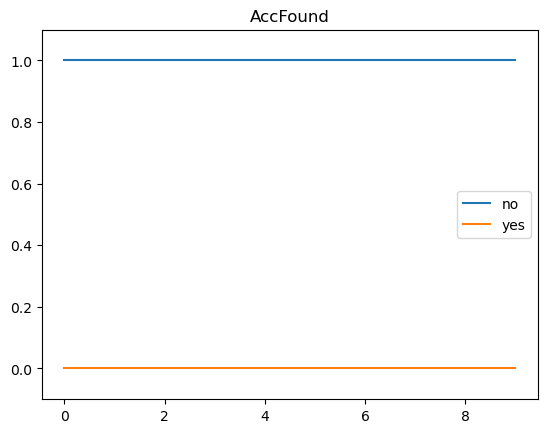

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


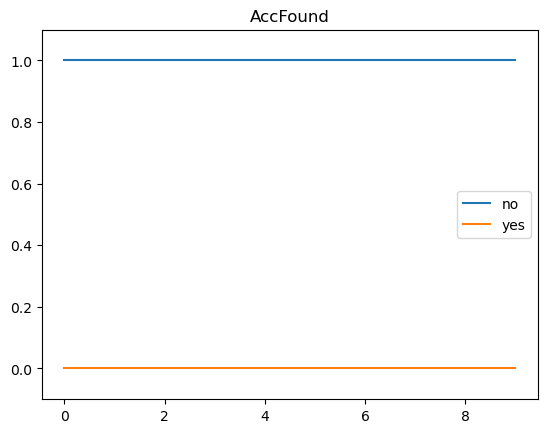

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.280000,0.720000
4,0.704918,0.295082
5,0.704918,0.295082
6,0.779893,0.220107
7,0.784310,0.215690
8,0.784333,0.215667
9,0.784333,0.215667


Plotting ('AccFound', ['no', 'yes']) for agent_j


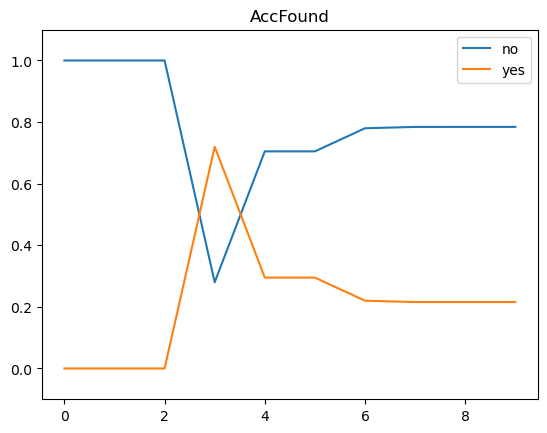

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


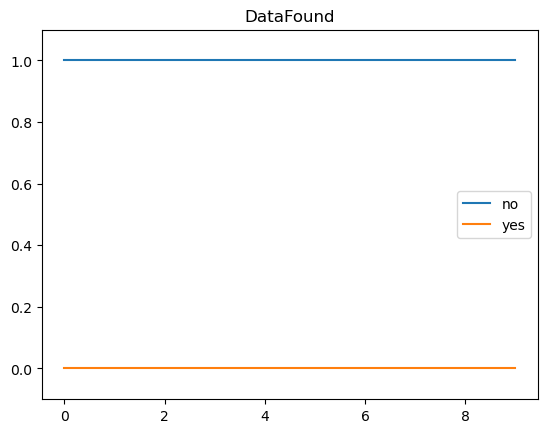

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.972973,0.027027
2,0.972973,0.027027
3,0.972973,0.027027
4,0.972973,0.027027
5,0.972973,0.027027
6,0.972973,0.027027
7,0.972973,0.027027
8,0.972973,0.027027
9,0.972973,0.027027


Plotting ('DataFound', ['no', 'yes']) for agent_i


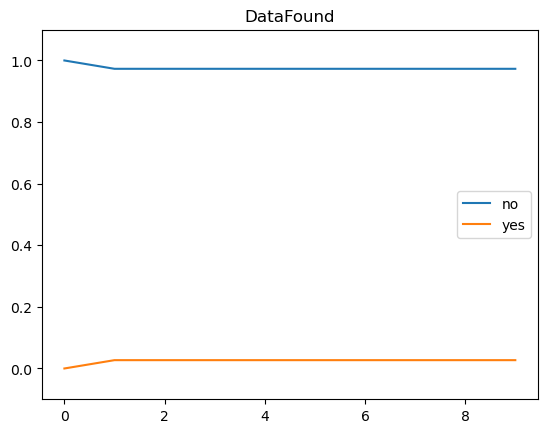

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_j


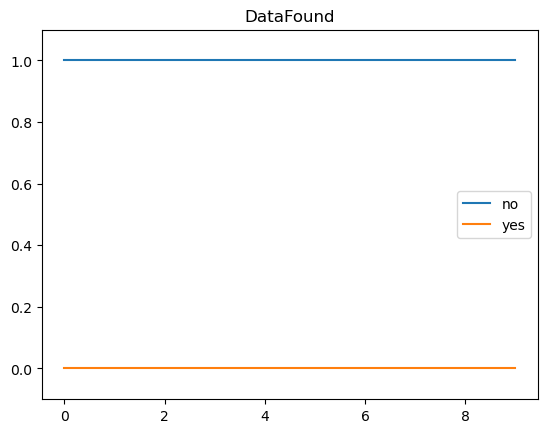

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


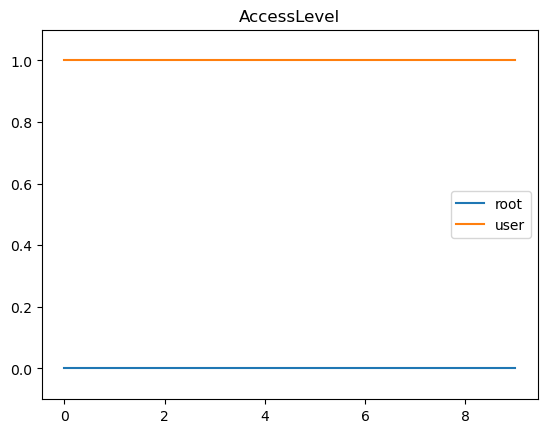

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


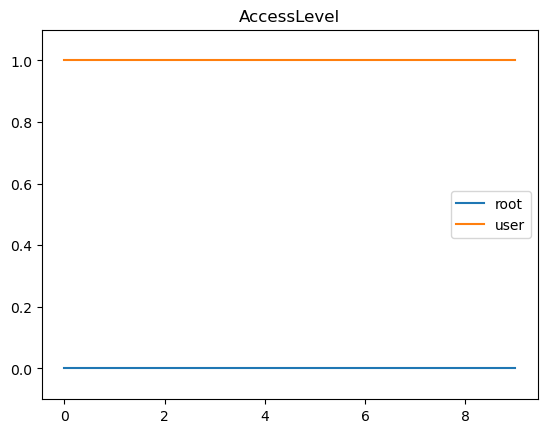

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.102144,0.897856
5,0.102144,0.897856
6,0.006648,0.993352
7,0.001022,0.998977
8,0.000992,0.999008
9,0.000992,0.999007


Plotting ('AccessLevel', ['root', 'user']) for agent_j


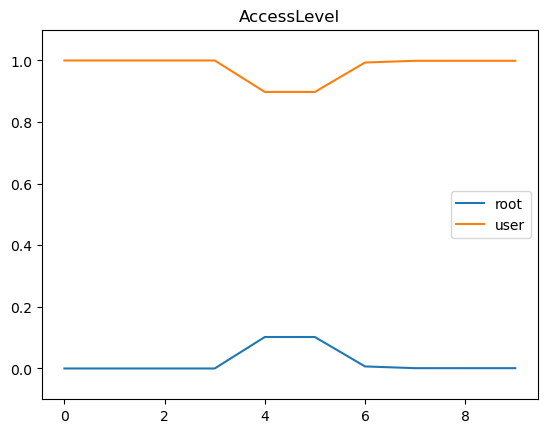

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


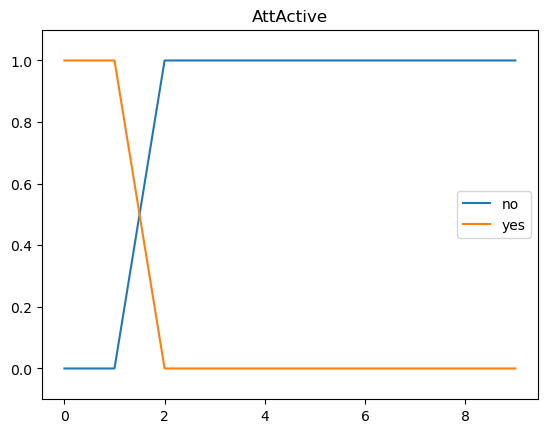

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


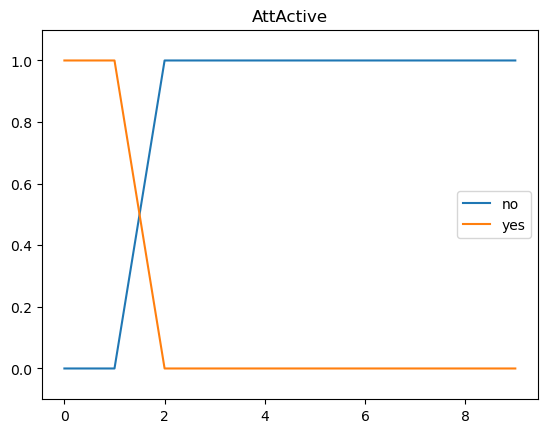

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.895019,0.104981
5,0.897856,0.102144
6,0.993352,0.006648
7,0.999646,0.000354
8,0.999998,0.000002
9,1.000000,0.000000


Plotting ('AttActive', ['no', 'yes']) for agent_j


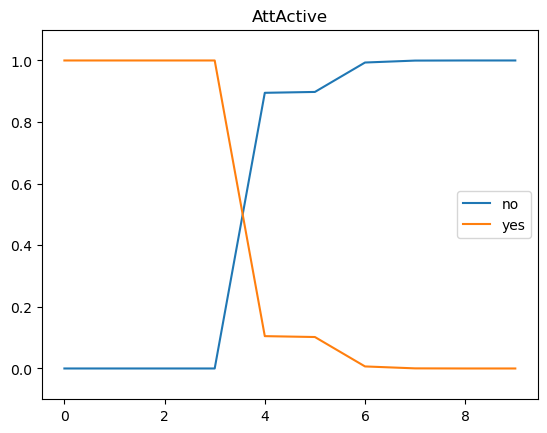

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


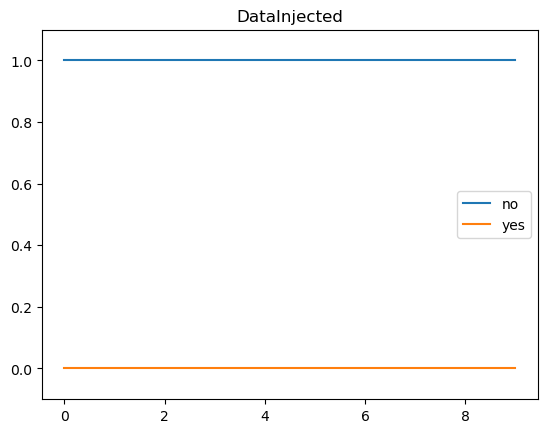

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


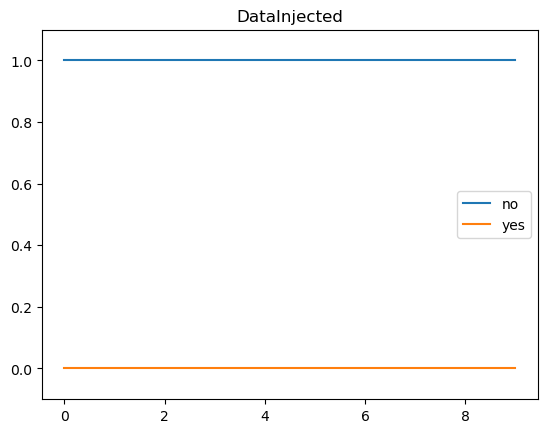

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_j


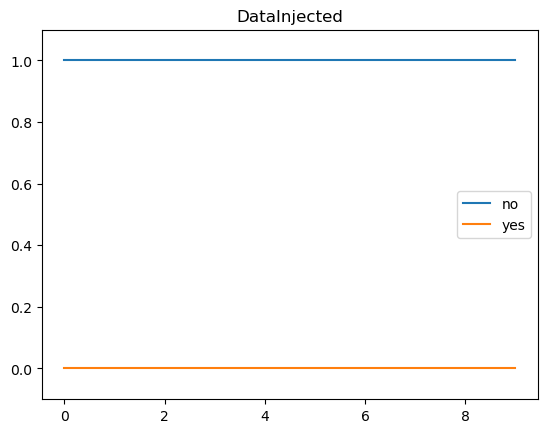

=============== End interaction trace


In [9]:
from IPython.display import display, HTML

for trace in data[:5]:
    actions = summarize_interaction.pull_actions(trace)
    frame_beliefs = summarize_interaction.pull_frame_beliefs(trace)
    
    for _b_theta in frame_beliefs:
        display(_b_theta)
        _b_theta.plot()
        plotter.ylim(-0.1, 1.1)
        plotter.show()
    
    display(actions)
    
    for k in keys:
        beliefs = summarize_interaction.show_belief(trace, k)
        
        for _b in beliefs.keys():
            print(f"Showing {k} for {_b}")
            display(beliefs[_b])
            
            print(f"Plotting {k} for {_b}")
            beliefs[_b].plot(legend=True, title=k[0])
            plotter.ylim(-0.1, 1.1)
            plotter.show()
            
    print("=============== End interaction trace")